### Credit Card Fraud Analysis
    - Identifying applicants to flag who are likely to default
    - Identiying important factors that indicate towards default

Importing Packages

In [827]:
library(lubridate)
library(dplyr)
library(ggplot2)
library(tidyr)
library(data.table)
library(corrplot)
library(fastDummies)
library(caret)
library(ROCR)
library(ROCit)
library(ROSE)
library(randomForest)
setwd("C:/Users/pares/OneDrive/Documents/assessments/net pay advance")
getwd()

[1] "C:/Users/pares/OneDrive/Documents/assessments/net pay advance"

# DATA

In [424]:
test_set <- read.csv("2018-05-17 - Recruit Sample Data Test.csv",stringsAsFactors = FALSE)
train_set <- read.csv("2018-05-17 - Recruit Sample Data Train.csv",stringsAsFactors = FALSE)
combined_data <- rbind(train_set,test_set)

In [425]:
str(combined_data)

'data.frame':	2000 obs. of  13 variables:
 $ SetID                : int  436 615 1251 440 1692 804 294 697 713 508 ...
 $ Time.of.Application  : chr  "2018-03-28T17:27:35Z" "2018-03-23T13:19:32Z" "2018-02-28T12:04:56Z" "2018-03-28T15:47:59Z" ...
 $ State                : chr  "CA" "TX" "CA" "CA" ...
 $ Monthly.Net.Income   : num  2000 3500 3000 1500 2392 ...
 $ Paycheck.Net.Income  : num  2000 3500 3000 1500 598 ...
 $ Rent.or.Own          : chr  "R" "R" "R" "R" ...
 $ Months.at.Residence  : int  12 60 0 12 130 12 36 37 60 24 ...
 $ Bank.Account.Months  : int  6 60 6 6 36 12 12 36 60 15 ...
 $ Pay.Cycle            : chr  "Monthly" "Monthly" "Monthly" "Monthly" ...
 $ Loan.Amount          : num  300 642 118 118 300 ...
 $ Loan.Funded.Date     : chr  "2018-03-28" "2018-03-23" "2018-02-28" "2018-03-28" ...
 $ Loan.Due.Date        : chr  "2018-04-11" "2018-04-06" "2018-03-30" "2018-04-28" ...
 $ First.Payment.Default: logi  FALSE FALSE TRUE FALSE FALSE FALSE ...


The data comes from a lending company called "Net Pay Advance" that lends small amounts of loans to consumers. The company operates in Califronia and Texas and wants to identify customers that are likely to default their first payments. We are tasked to identify important factors leading to default and flagging customers likely to default

In [426]:
head(combined_data)

,SetID,Time.of.Application,State,Monthly.Net.Income,Paycheck.Net.Income,Rent.or.Own,Months.at.Residence,Bank.Account.Months,Pay.Cycle,Loan.Amount,Loan.Funded.Date,Loan.Due.Date,First.Payment.Default
,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<lgl>
1,436,2018-03-28T17:27:35Z,CA,2000,2000,R,12,6,Monthly,300.00,2018-03-28,2018-04-11,FALSE
2,615,2018-03-23T13:19:32Z,TX,3500,3500,R,60,60,Monthly,641.91,2018-03-23,2018-04-06,FALSE
3,1251,2018-02-28T12:04:56Z,CA,3000,3000,R,0,6,Monthly,117.65,2018-02-28,2018-03-30,TRUE
4,440,2018-03-28T15:47:59Z,CA,1500,1500,R,12,6,Monthly,117.65,2018-03-28,2018-04-28,FALSE
5,1692,2018-02-13T04:36:00Z,CA,2392,598,R,130,36,Weekly,300.00,2018-02-13,2018-02-23,FALSE
6,804,2018-03-17T11:17:38Z,TX,5000,2500,R,12,12,BiWeekly,385.06,2018-03-19,2018-03-30,FALSE


Here, we have information on 2000 customers, where we have 13 variables associated to each of them.

There are 2 types of information available to us:
1. Applicant/ Customer provided information relating to his/her location, home details, bank details, etc.
2. Loan related information


- We have 5 numerical variables, 3 categorical variables and 3 date columns.
- We need to convert data types of all variables with incorrect data-types.

In [427]:
#Converting date columns to correct data types
combined_data$Time.of.Application <- ymd_hms(combined_data$Time.of.Application)
combined_data$Loan.Funded.Date <- ymd(combined_data$Loan.Funded.Date)
combined_data$Loan.Due.Date <- ymd(combined_data$Loan.Due.Date)
#Converting categorical columns to correct data types
combined_data$State <- as.factor(combined_data$State)
combined_data$Rent.or.Own <- as.factor(combined_data$Rent.or.Own)
combined_data$Pay.Cycle <- as.factor(combined_data$Pay.Cycle)
#Converting target variable to binary from boolean
#combined_data$First.Payment.Default <- as.numeric(combined_data$First.Payment.Default)
#combined_data$First.Payment.Default <- as.factor(combined_data$First.Payment.Default)

In [428]:
combined_data$First.Payment.Default[combined_data$First.Payment.Default == "FALSE"] = "no"
combined_data$First.Payment.Default[combined_data$First.Payment.Default == "TRUE"] = "yes"
combined_data$First.Payment.Default <- as.factor(combined_data$First.Payment.Default)

In [429]:
#sanity check
str(combined_data)

'data.frame':	2000 obs. of  13 variables:
 $ SetID                : int  436 615 1251 440 1692 804 294 697 713 508 ...
 $ Time.of.Application  : POSIXct, format: "2018-03-28 17:27:35" "2018-03-23 13:19:32" ...
 $ State                : Factor w/ 2 levels "CA","TX": 1 2 1 1 1 2 1 1 1 2 ...
 $ Monthly.Net.Income   : num  2000 3500 3000 1500 2392 ...
 $ Paycheck.Net.Income  : num  2000 3500 3000 1500 598 ...
 $ Rent.or.Own          : Factor w/ 2 levels "O","R": 2 2 2 2 2 2 2 2 2 2 ...
 $ Months.at.Residence  : int  12 60 0 12 130 12 36 37 60 24 ...
 $ Bank.Account.Months  : int  6 60 6 6 36 12 12 36 60 15 ...
 $ Pay.Cycle            : Factor w/ 4 levels "BiMonthly","BiWeekly",..: 3 3 3 3 4 2 2 1 2 2 ...
 $ Loan.Amount          : num  300 642 118 118 300 ...
 $ Loan.Funded.Date     : Date, format: "2018-03-28" "2018-03-23" ...
 $ Loan.Due.Date        : Date, format: "2018-04-11" "2018-04-06" ...
 $ First.Payment.Default: Factor w/ 2 levels "no","yes": 1 1 2 1 1 1 2 1 2 2 ...


Everything looks alright now. Before proceeding, we need to separate training data from combined_data for analysis so that we dont mix testing set, while understanding the data (If we encounter anomalies and decide to replace/change values - we'll do it using combined_data to make changes in training and testing sets both.)

In [430]:
train <- combined_data %>% filter(!is.na(First.Payment.Default))

## Cleaning Data

In [431]:
#Duplicated observations
anyDuplicated(combined_data)

[1] 0

No duplicated customers!!!

In [432]:
#removing variables that will contribute to noise
clean_data <- combined_data %>%
                    select(-"SetID")

In [433]:
summary(clean_data)

 Time.of.Application           State     Monthly.Net.Income Paycheck.Net.Income
 Min.   :2018-01-31 14:52:00   CA:1453   Min.   :    70     Min.   :    70     
 1st Qu.:2018-02-20 08:18:15   TX: 547   1st Qu.:  2000     1st Qu.:  1250     
 Median :2018-03-09 15:43:09             Median :  3262     Median :  2194     
 Mean   :2018-03-09 03:56:19             Mean   :  4433     Mean   :  2756     
 3rd Qu.:2018-03-27 11:10:07             3rd Qu.:  5250     3rd Qu.:  3500     
 Max.   :2018-04-09 23:25:18             Max.   :211912     Max.   :184000     
 Rent.or.Own Months.at.Residence Bank.Account.Months     Pay.Cycle  
 O: 245      Min.   :  0.00      Min.   :  3.00      BiMonthly:247  
 R:1755      1st Qu.: 17.00      1st Qu.:  6.00      BiWeekly :904  
             Median : 38.50      Median : 24.00      Monthly  :728  
             Mean   : 62.89      Mean   : 24.68      Weekly   :121  
             3rd Qu.: 80.00      3rd Qu.: 36.00                     
             Max.   :690.0

There does not seem to be any missing values in the data. First Payment Default has 400 missing values that belong to test data

In [434]:
#Separating numerical, categorical columns
cat_cols <- c("State","Rent.or.Own","Pay.Cycle")
numerical <- c("Monthly.Net.Income","Paycheck.Net.Income","Months.at.Residence","Bank.Account.Months","Loan.Amount")

# Analyzing each variable individually - UNIVARIATE ANALYSIS

#### Numerical Variables

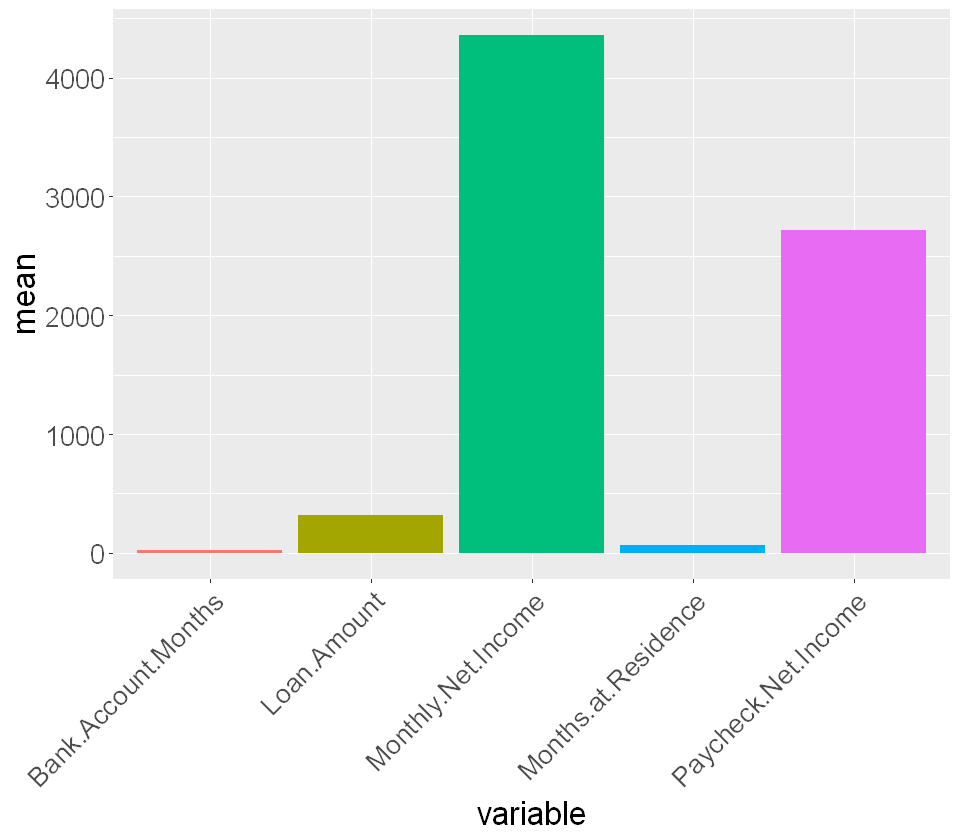

In [435]:
#Mean distribution
options(repr.plot.width = 8, repr.plot.height = 7)
mean_dist <- sapply(train %>% select(numerical), function(x) mean(x))
df_mean <- data.frame(NA,ncols = 2)
for (i in 1:length(mean_dist)){
    df_mean[i,] <- c(names(mean_dist[i]),round(mean_dist[i],2))
}
colnames(df_mean) <- c("variable","mean")
df_mean$mean <- as.numeric(df_mean$mean)
ggplot(data = df_mean,aes(x = variable,y = mean,fill = variable)) + geom_bar(stat = "identity") + theme(text = element_text(size=20),
                                                                                        axis.text.x = element_text(angle= 45,hjust=1),legend.position = "none")

- Clearly, the means of variables differ to a high degree. We need to scale our variables before modelling.

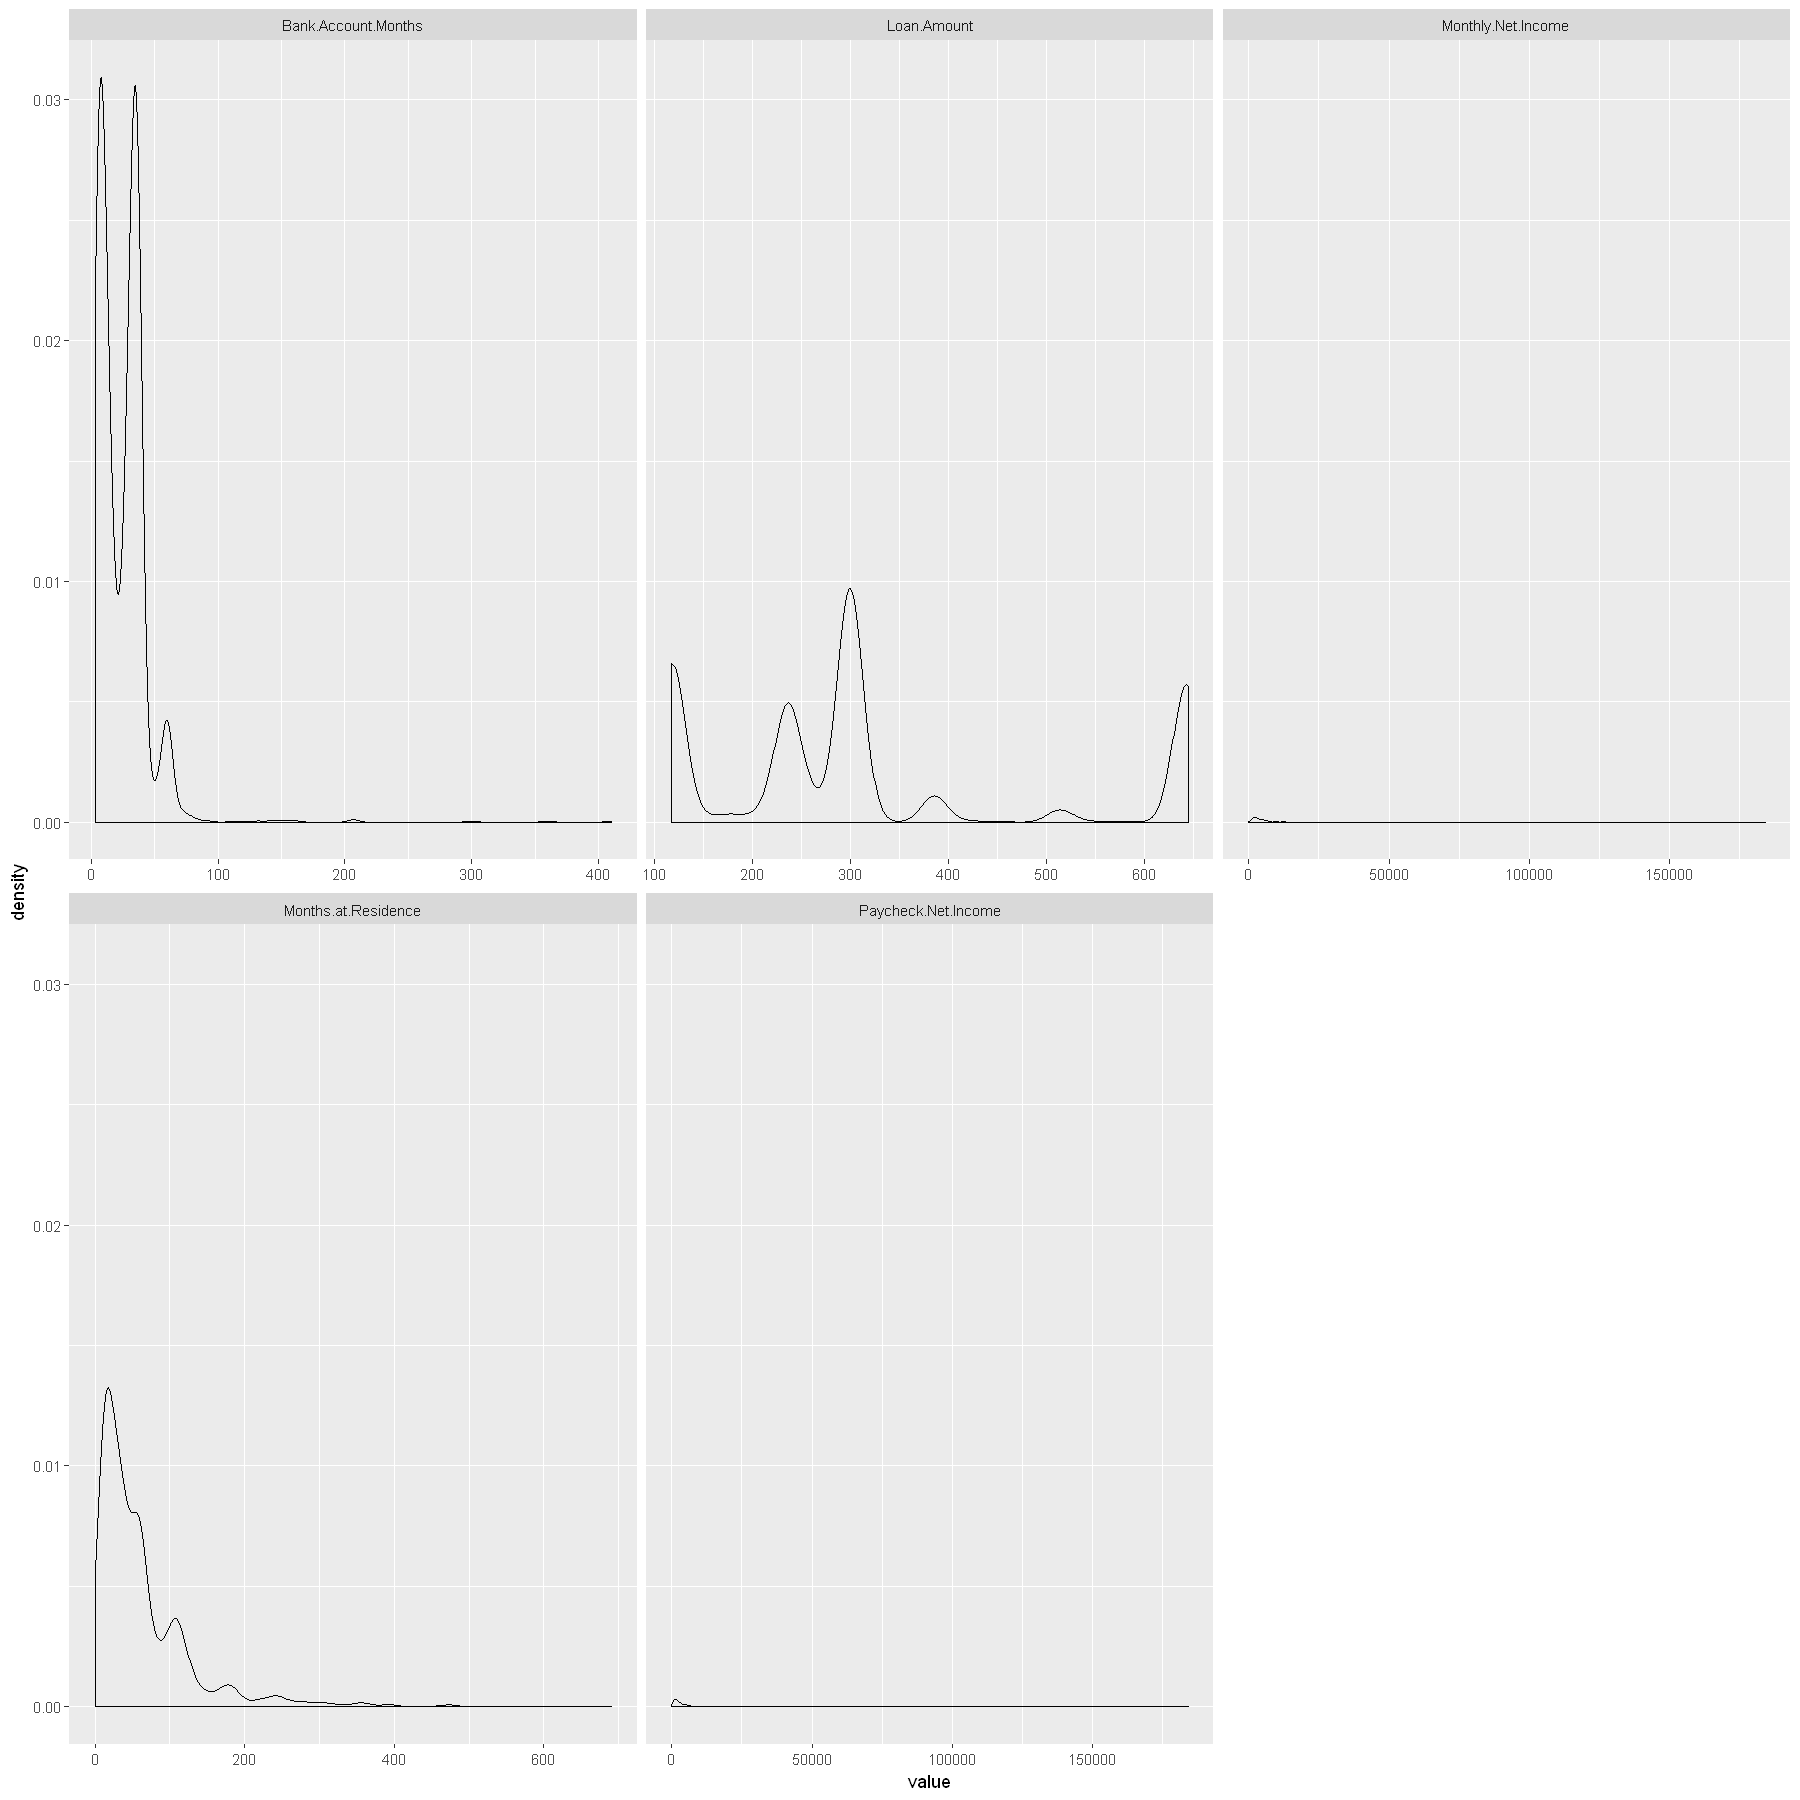

In [436]:
#Density plots of all numerical variables
options(repr.plot.width = 15, repr.plot.height = 15)
ggplot(gather(train %>% select(numerical)), aes(x = value)) + 
geom_density() +
facet_wrap(~key,scales = "free_x")

All of them are skewed. The outliers need to be further analyzed. Loan Amount has 4 separate peaks, all these peaks need to be further analyzed

### Categorical variable

- Target variable


      no      yes 
0.734375 0.265625 

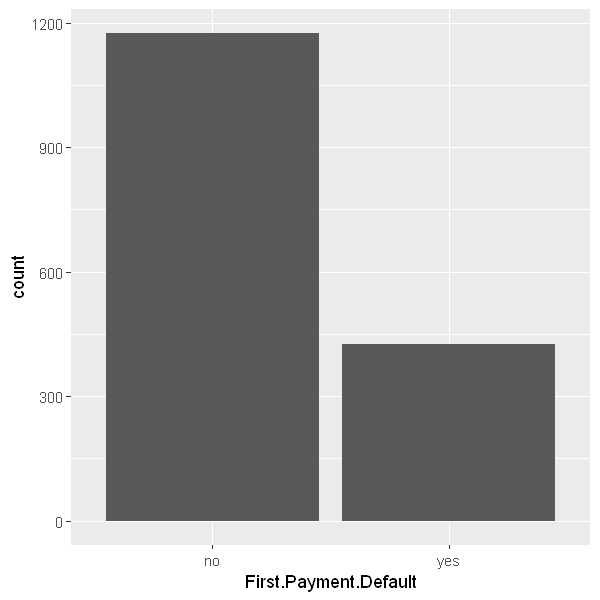

In [437]:
options(repr.plot.width = 5, repr.plot.height = 5)
prop.table(table(train$First.Payment.Default))
ggplot(data = train,aes(x = First.Payment.Default)) +
geom_bar()

There is a huge class imbalance issue here. We will initially try to model classes and data as is, and based on the results, decide if we want to up-sample or down-sample the data, or use SMOTE technique to level the classes. For evaluation, apart from accuracy, we will also look at confusion matrix and ROC- curve.

Warning message:
"attributes are not identical across measure variables;
they will be dropped"


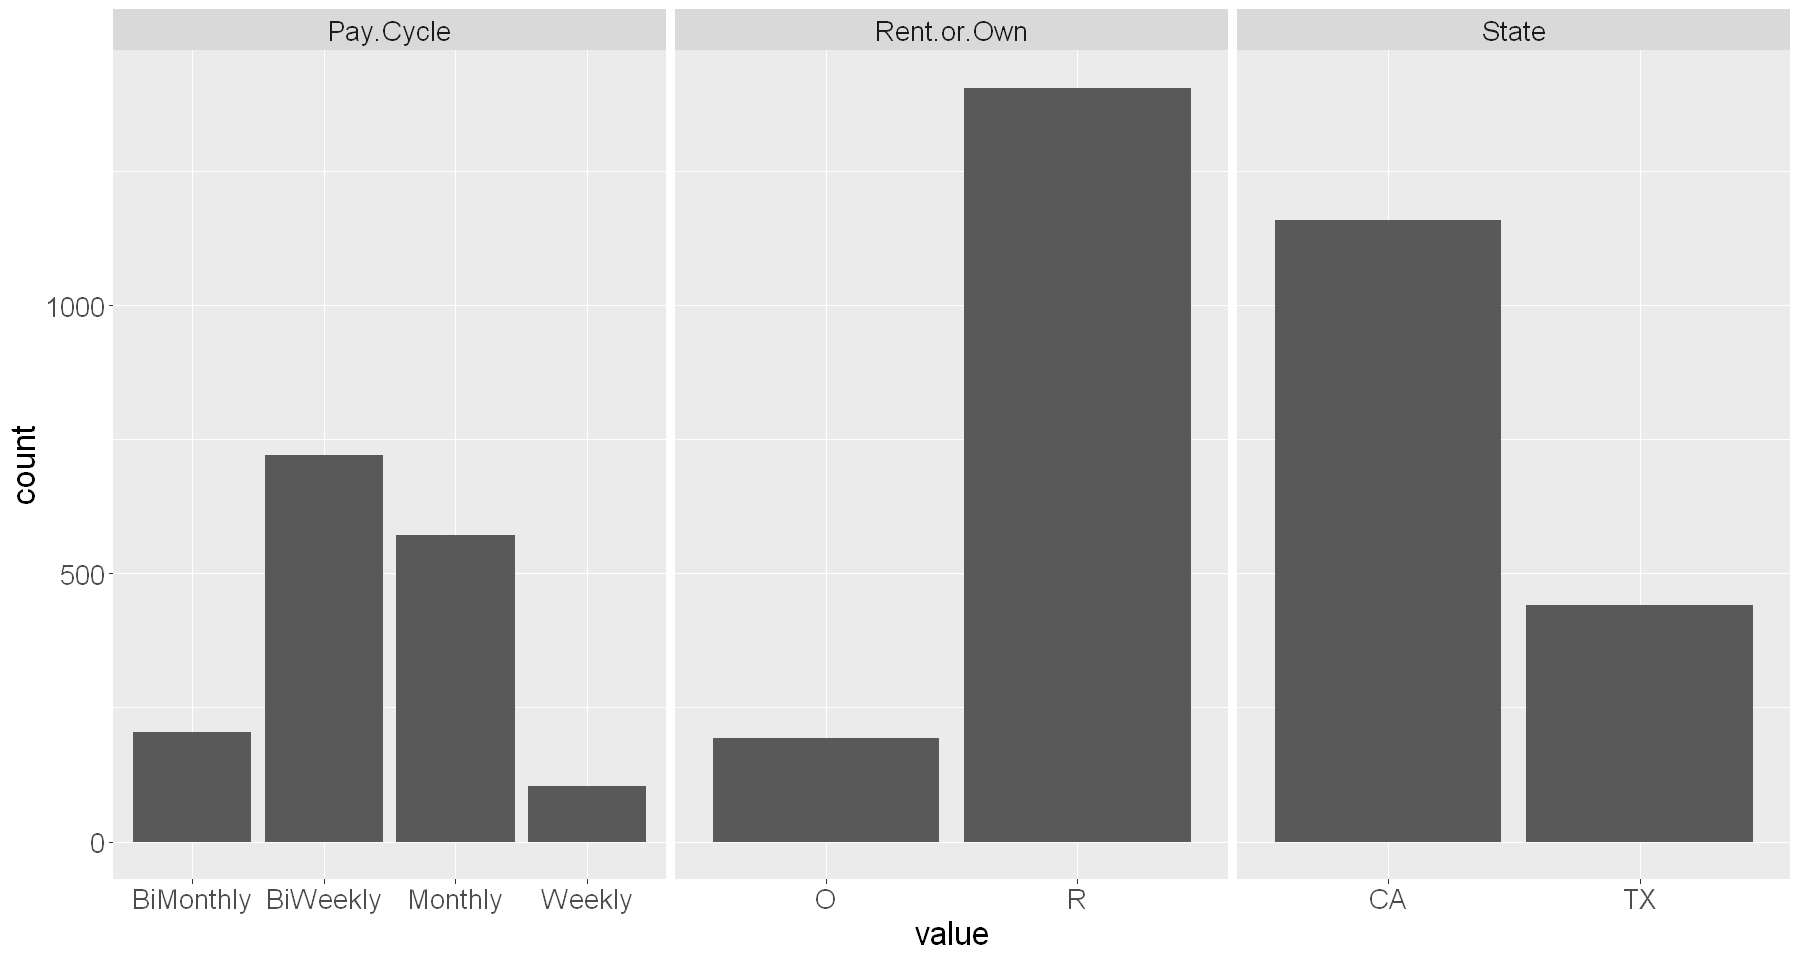

In [438]:
options(repr.plot.width = 15, repr.plot.height = 8)
ggplot(gather(train %>% select(cat_cols)), aes(x = value)) + 
geom_bar() +
facet_wrap(~key,scales = "free_x") + theme(text = element_text(size =20))

- The majority of the population comes for California, live in a rented house and prefer a bi-monthly and monthly pay-cycle.

- Overall, there does not seem to be any data consistency issues here, or any invalid values. Therefore, we can move on to understand what each variable represents and their relationships.

# Outliers

* Monthly Net Income

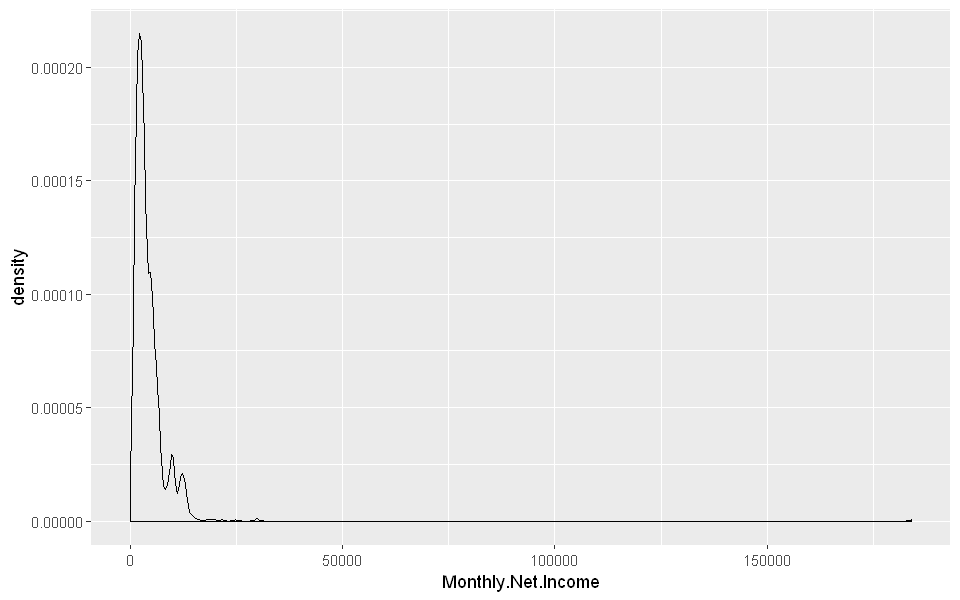

In [439]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(data = train,aes(x = Monthly.Net.Income)) +
geom_density()

In [440]:
train %>% 
filter(Monthly.Net.Income > 50000)

SetID,Time.of.Application,State,Monthly.Net.Income,Paycheck.Net.Income,Rent.or.Own,Months.at.Residence,Bank.Account.Months,Pay.Cycle,Loan.Amount,Loan.Funded.Date,Loan.Due.Date,First.Payment.Default
<int>,<dttm>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<fct>,<dbl>,<date>,<date>,<fct>
1771,2018-02-10 20:34:00,TX,184000,184000,O,115,36,Monthly,642.46,2018-02-11,2018-02-28,yes


A customer with a monthly net income of USD 184,000 asking for a loan amount USD 642 seems odd. And the customer defaulted too.
Looks like income is a self-reported figure and not much background check is done. However, it is hard to determine if the value is an error, and therefore, I will keep it for analysis.

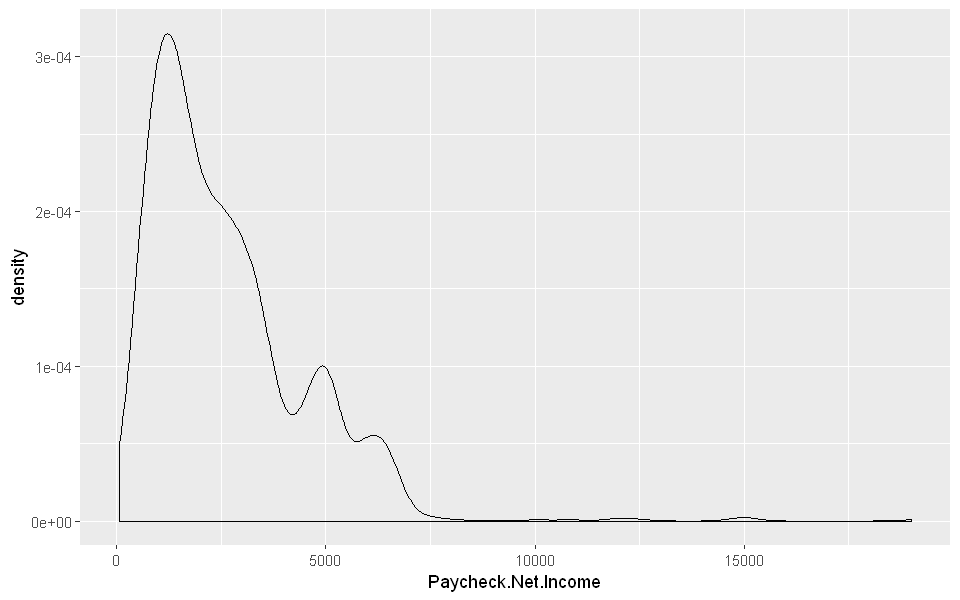

In [441]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(data = train %>% filter(Paycheck.Net.Income <= 50000),aes(x = Paycheck.Net.Income)) +
geom_density()

In [442]:
train %>%
filter(Paycheck.Net.Income > 10000)

SetID,Time.of.Application,State,Monthly.Net.Income,Paycheck.Net.Income,Rent.or.Own,Months.at.Residence,Bank.Account.Months,Pay.Cycle,Loan.Amount,Loan.Funded.Date,Loan.Due.Date,First.Payment.Default
<int>,<dttm>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<fct>,<dbl>,<date>,<date>,<fct>
1461,2018-02-21 08:43:07,TX,30000,15000,R,36,6,BiMonthly,640.95,2018-02-21,2018-02-28,no
796,2018-03-17 21:21:59,CA,12000,12000,R,50,36,Monthly,117.65,2018-03-18,2018-04-03,no
818,2018-03-16 15:21:13,TX,25000,12500,R,36,6,BiWeekly,642.60,2018-03-16,2018-04-04,no
1609,2018-02-14 17:21:00,CA,15000,15000,R,76,113,Monthly,235.30,2018-02-14,2018-03-02,no
1611,2018-02-14 16:05:00,CA,30000,15000,R,88,50,BiWeekly,235.30,2018-02-14,2018-02-23,no
1998,2018-01-31 15:03:00,CA,19000,19000,R,50,36,Monthly,300.00,2018-01-31,2018-02-28,no
1383,2018-02-23 14:50:43,TX,21732,10866,R,12,12,BiWeekly,640.95,2018-02-23,2018-03-02,no
1895,2018-02-05 11:02:00,CA,12018,12018,R,210,36,Monthly,300.00,2018-02-05,2018-02-20,no
1771,2018-02-10 20:34:00,TX,184000,184000,O,115,36,Monthly,642.46,2018-02-11,2018-02-28,yes


I will keep all these outliers for analysis
### Months at Residence

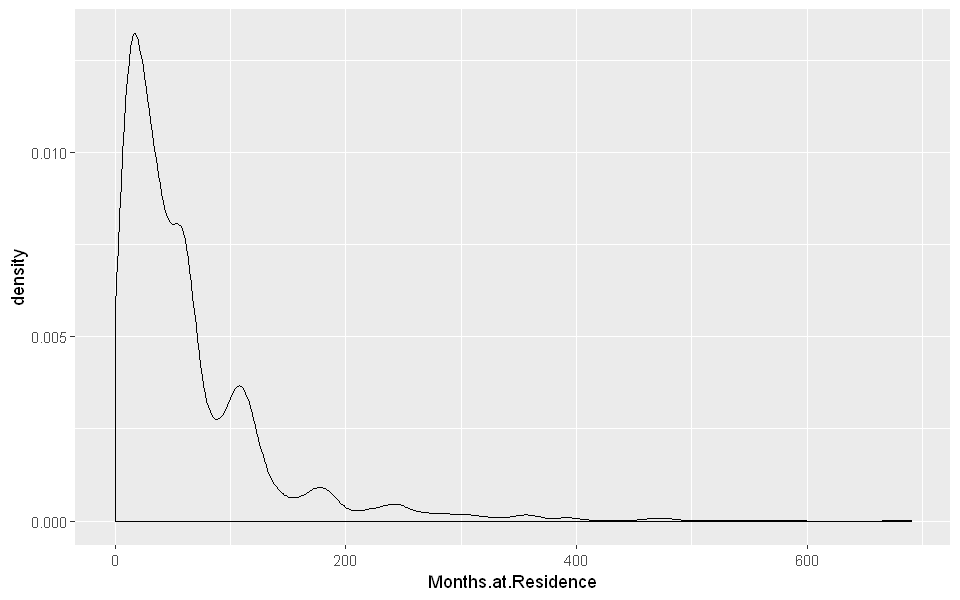

In [443]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(data = train,aes(x = Months.at.Residence)) +
geom_density()

In [444]:
train %>%
filter(Months.at.Residence > 400)

SetID,Time.of.Application,State,Monthly.Net.Income,Paycheck.Net.Income,Rent.or.Own,Months.at.Residence,Bank.Account.Months,Pay.Cycle,Loan.Amount,Loan.Funded.Date,Loan.Due.Date,First.Payment.Default
<int>,<dttm>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<fct>,<dbl>,<date>,<date>,<fct>
708,2018-03-20 14:50:46,CA,3513,3513,R,473,36,Monthly,300.00,2018-03-20,2018-03-30,no
1693,2018-02-12 22:56:00,CA,3846,3846,O,511,36,Monthly,300.00,2018-02-13,2018-03-01,no
1498,2018-02-20 10:36:24,CA,4000,2000,R,460,36,BiWeekly,300.00,2018-02-20,2018-03-01,no
1787,2018-02-09 12:46:00,CA,5988,5988,O,575,15,Monthly,300.00,2018-02-09,2018-03-02,no
1386,2018-02-23 14:31:47,CA,3400,3400,O,533,36,Monthly,264.71,2018-02-23,2018-03-05,no
1226,2018-03-01 10:45:48,TX,3500,3500,R,473,32,Monthly,642.60,2018-03-01,2018-03-20,no
707,2018-03-20 15:22:36,CA,811,811,O,690,36,Monthly,264.71,2018-03-20,2018-04-02,no
411,2018-03-29 13:29:59,CA,2553,2553,O,480,36,Monthly,300.00,2018-03-29,2018-04-09,yes
1880,2018-02-05 14:02:00,CA,2022,1011,O,426,36,BiWeekly,300.00,2018-02-05,2018-02-23,no


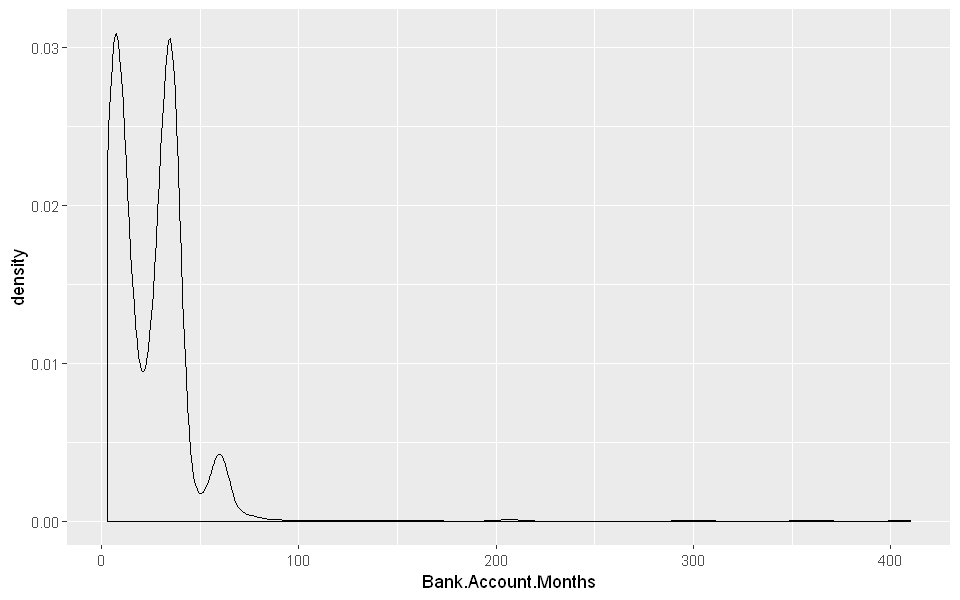

In [445]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(data = train,aes(x = Bank.Account.Months)) +
geom_density()

In [446]:
train %>%
filter(Bank.Account.Months > 200)

SetID,Time.of.Application,State,Monthly.Net.Income,Paycheck.Net.Income,Rent.or.Own,Months.at.Residence,Bank.Account.Months,Pay.Cycle,Loan.Amount,Loan.Funded.Date,Loan.Due.Date,First.Payment.Default
<int>,<dttm>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<fct>,<dbl>,<date>,<date>,<fct>
1395,2018-02-23 11:18:44,CA,9000,4500,R,15,300,BiWeekly,235.30,2018-02-23,2018-03-09,no
788,2018-03-18 13:55:55,CA,9600,4800,R,212,206,BiWeekly,235.30,2018-03-18,2018-04-06,no
1501,2018-02-20 08:02:49,TX,10000,5000,R,120,360,BiMonthly,642.05,2018-02-20,2018-03-07,no
1596,2018-02-14 19:54:00,CA,5400,2700,R,107,208,BiWeekly,294.12,2018-02-15,2018-03-02,no
1613,2018-02-14 16:02:00,CA,6000,3000,R,128,410,BiWeekly,235.30,2018-02-15,2018-02-22,no


Looking at the outliers, it is hard to determine whether any of it is a data entry error. I will keep them for now.

### Loan Amount

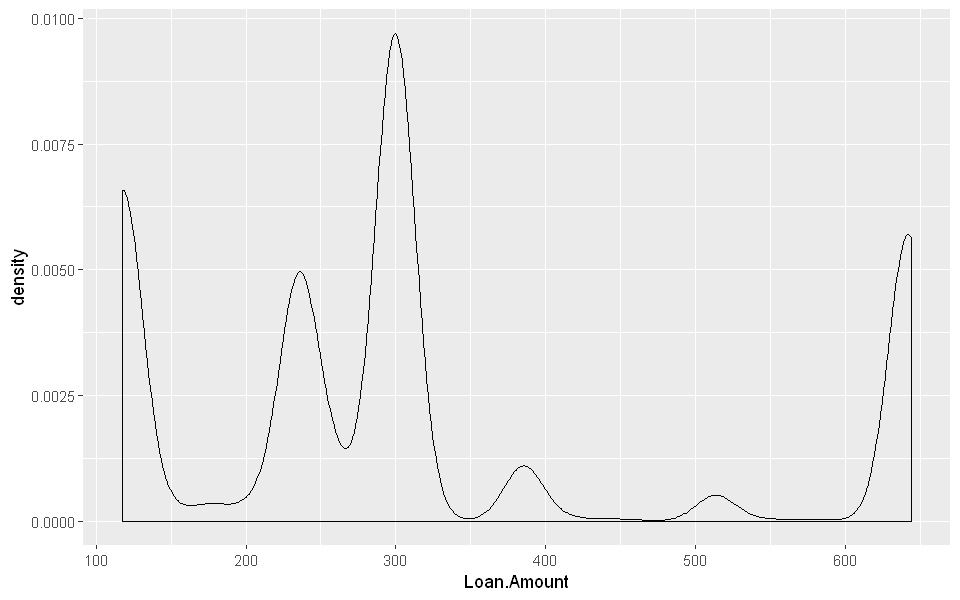

In [447]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(data = train,aes(x = Loan.Amount)) +
geom_density()

In [448]:
#Number of unique loan amounts
uniqueN(train$Loan.Amount)

[1] 113

In [449]:
head(sort(table(train$Loan.Amount),decreasing = TRUE),20)


   300 117.65  235.3 642.05 641.09 644.24 641.23 294.12  641.5 642.46 641.36 
   476    342    249     29     28     28     27     26     23     20     16 
176.47 641.91 264.71 641.78 642.19 642.32 147.06 640.95 205.88 
    15     15     14     14     13     13     12     11      9 

1600 customers have recieved 113 types of amounts. Looks like, a customer can qualify for a fixed amount of loan based on his/her credit. We can categorize the loan amounts to see if there is any trend there.

# Analyzing relationships - BIVARIATE ANALYSIS

#### - Categorical Variables

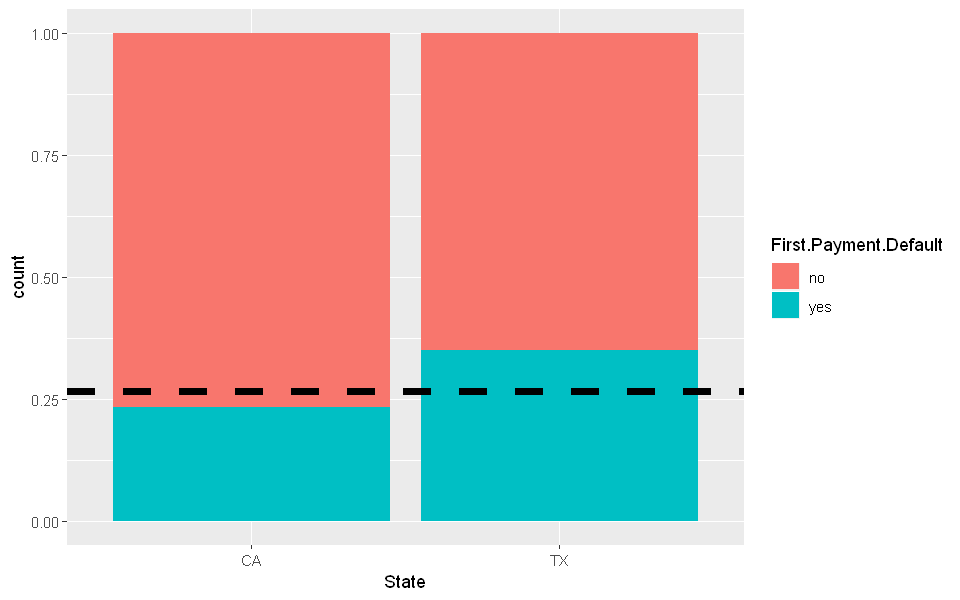

In [450]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(train, aes(x = State)) + 
geom_bar(aes(fill = First.Payment.Default),position = "fill") +
geom_hline(yintercept = .265,linetype = "dashed",size = 2)

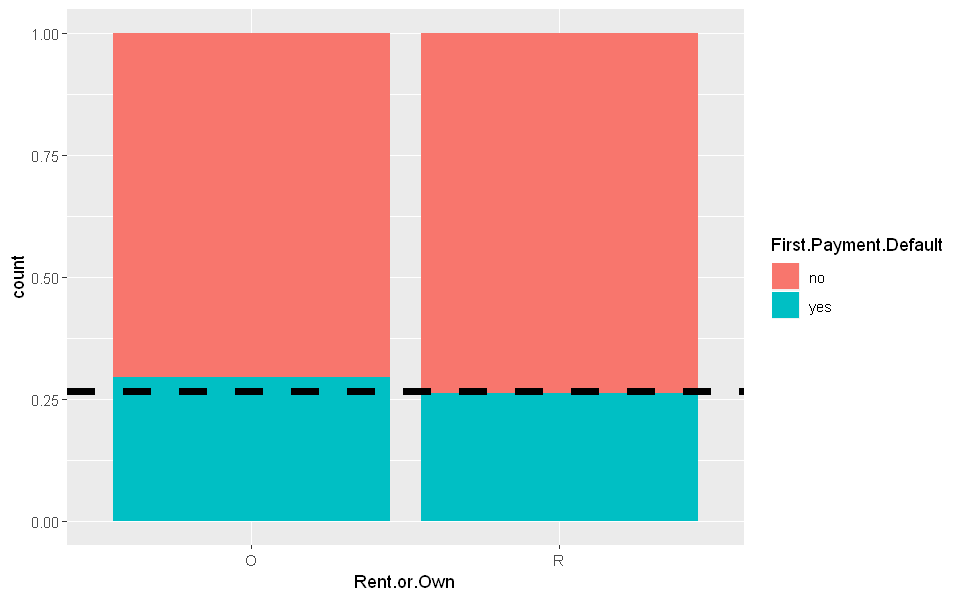

In [451]:
ggplot(train, aes(x = Rent.or.Own)) + 
geom_bar(aes(fill = First.Payment.Default),position = "fill") +
geom_hline(yintercept = .265,linetype = "dashed",size = 2)

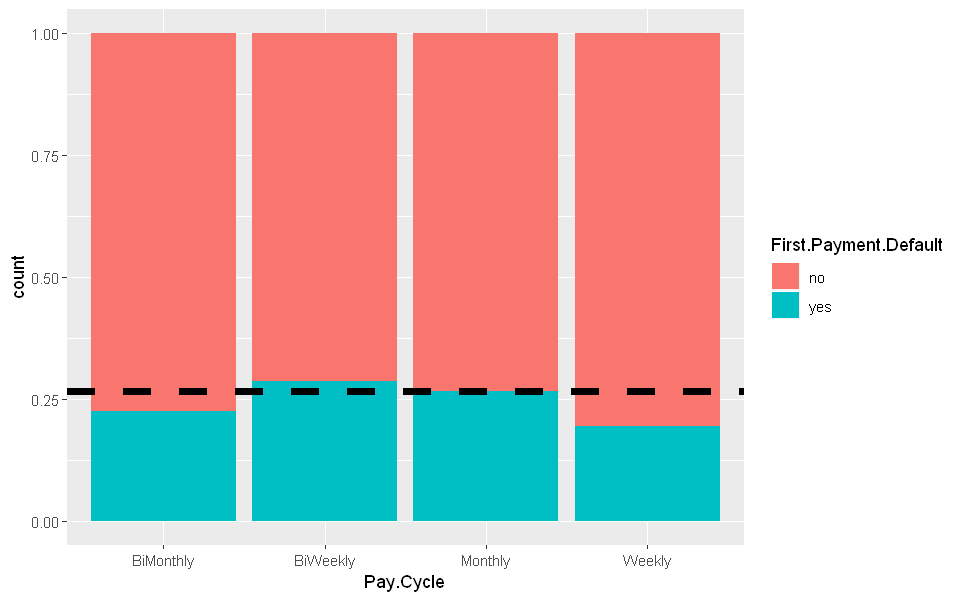

In [452]:
ggplot(train, aes(x = Pay.Cycle)) + 
geom_bar(aes(fill = First.Payment.Default),position = "fill") +
geom_hline(yintercept = .265,linetype = "dashed",size = 2)

The defaulting customers do not seem to vary much based on their states, housing or pay-cycle. Lets look at numerical variables.

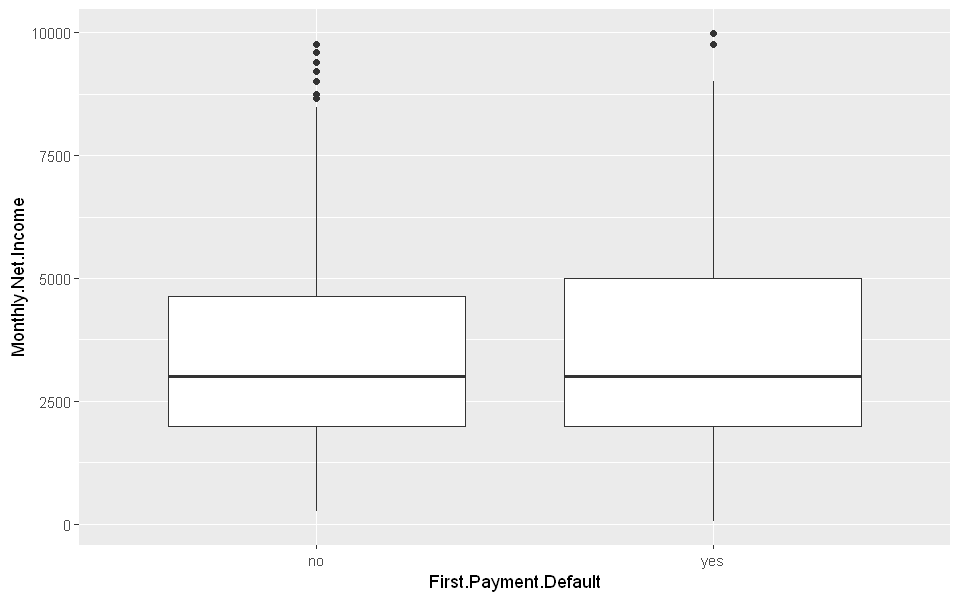

In [453]:
#removing the outlier to look at the distribution
ggplot(train %>% filter(Monthly.Net.Income < 10000), aes(x = First.Payment.Default, y =Monthly.Net.Income )) + 
geom_boxplot() 

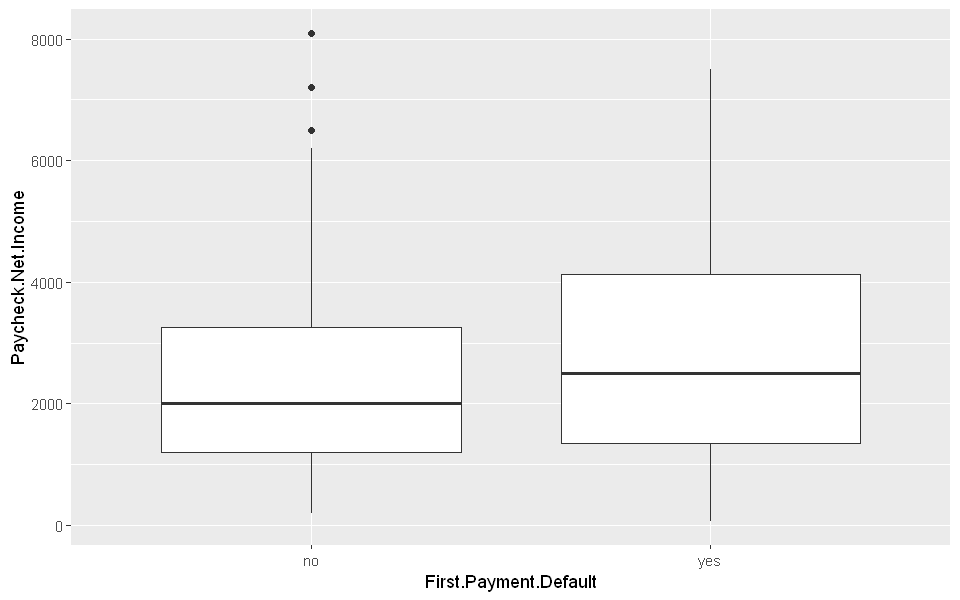

In [454]:
ggplot(train %>% filter(Paycheck.Net.Income < 10000), aes(x = First.Payment.Default, y =Paycheck.Net.Income )) + 
geom_boxplot() 

### Defaulters have reported a slightly higher net income coming from their paycheck.

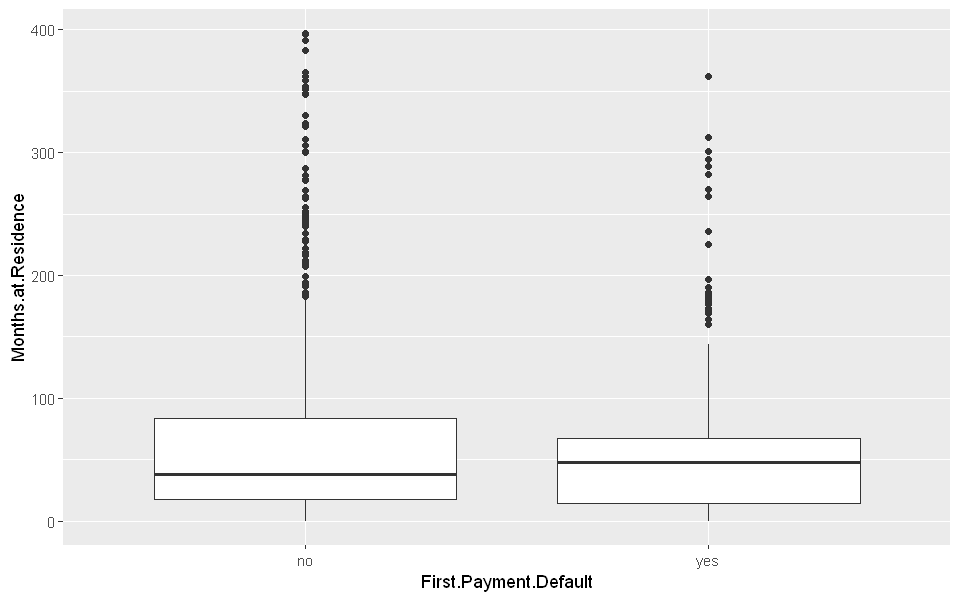

In [455]:
ggplot(train %>% filter(Months.at.Residence  < 400), aes(x = First.Payment.Default, y = Months.at.Residence )) + 
geom_boxplot() 

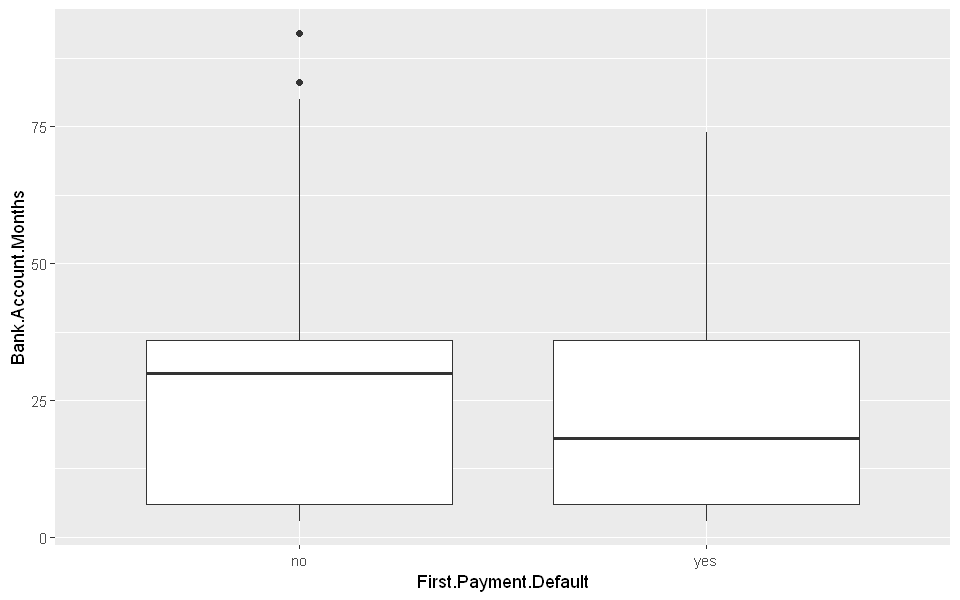

In [456]:
ggplot(train %>% filter(Bank.Account.Months  < 100), aes(x = First.Payment.Default, y = Bank.Account.Months )) + 
geom_boxplot() 

The defaulting customers have quite a significant difference in the means of distributions. This means, on average defaulting customers have had a bank account for a lower duration.

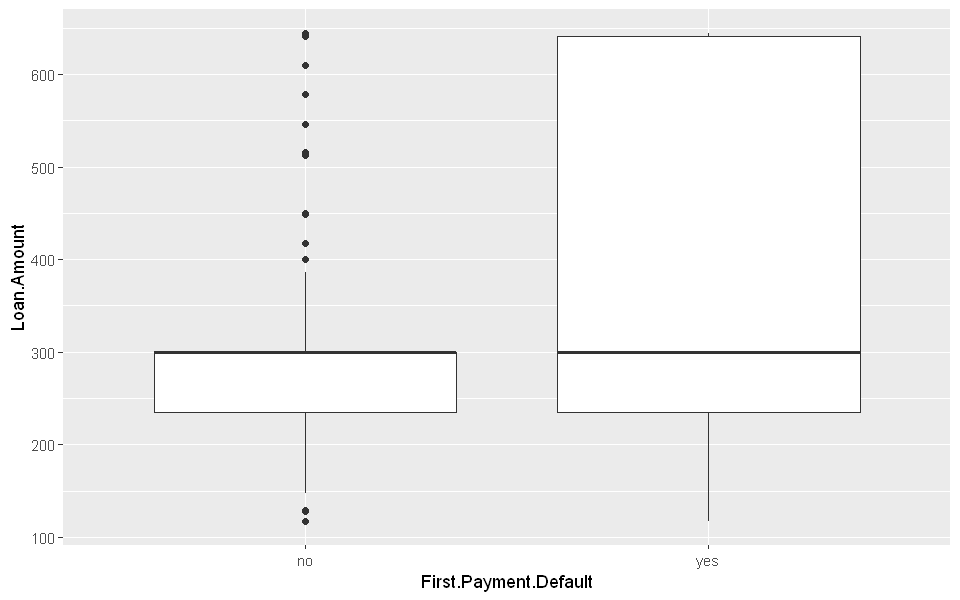

In [457]:
ggplot(train, aes(x = First.Payment.Default, y = Loan.Amount )) + 
geom_boxplot() 

The mean for two distributions is same, but defaulters have a large inter-quartile range. The defaulters ask for a higher amount for loan as compared to others.

# Lets explore some more relationships

- Things that we can look at:
1. Relationship between the Loan Amount asked and the customers Income
2. Understand, how pay-cycle works. And, how is the due-date caluclated?
3. Does population's income vary between different states, and does that increase the likelihood of customer asking for loan?
4. How is Loan Amount calculated? Does the customer have freedom to ask for any amount or he/she is qualified for a certain amount based on reported figures?

#### Are loan amounts related to applicant's income?

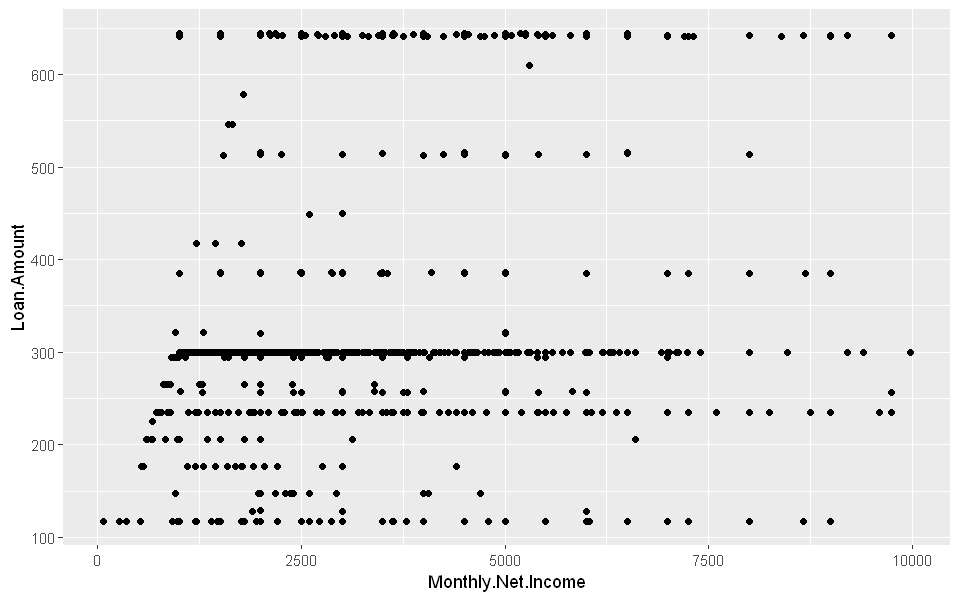

In [458]:
ggplot(data = train %>% filter(Monthly.Net.Income < 10000),aes(x = Monthly.Net.Income, y = Loan.Amount)) +
geom_point()

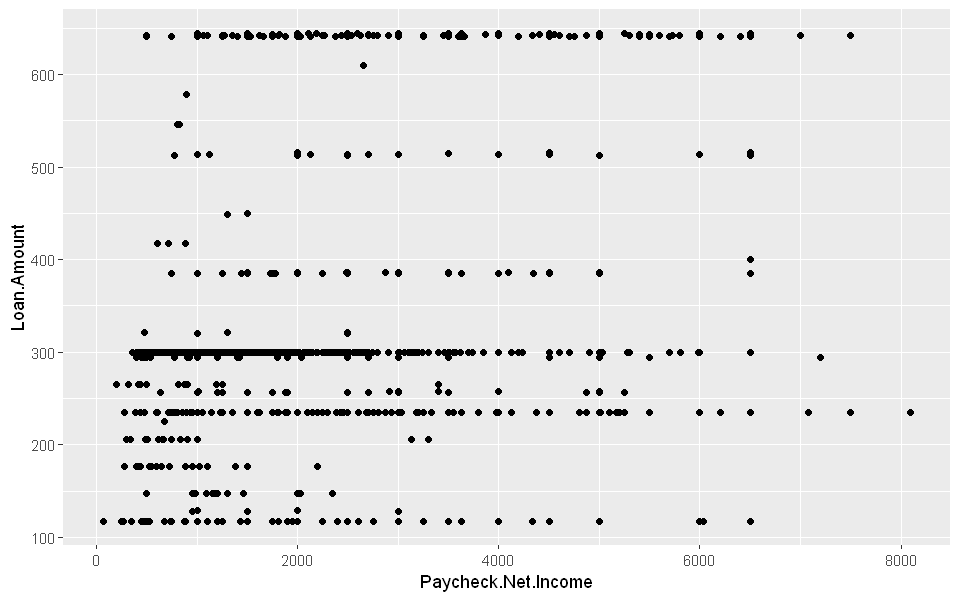

In [459]:
ggplot(data = train %>% filter(Paycheck.Net.Income < 10000),aes(x = Paycheck.Net.Income, y = Loan.Amount)) +
geom_point()

- There doesn't seem to be any relationship between applicant's income and the requested loan amounts

#### How is pay-cycle chosen? Can we determine how due date is calculated?

The company offers 2 different types of loans. Single Pay Loans and Installment Loans. Single Pay are supposed to be paid on the customer's next pay day (which may lie between 8 to 31 days). Installment Loans can be paid over 180 days. Also, there are 4 types of pay-cycles, where bi-weekly usually is referred to a single payment period in 2 weeks. And, Bi-Monthly refers to 2 payment periods in a month.

Lets look at the loan's funded date.

In [460]:
train$time.to.review <- difftime(train$Loan.Funded.Date, as_date(train$Time.of.Application) ,units = "days")

In [461]:
train %>%
filter(time.to.review > 1) %>%
select(First.Payment.Default) %>%
table() %>%
prop.table()

.
   no   yes 
0.625 0.375 

There are quite a few customers where the company took some time to approve the application. And, the default rate for these customers is higher than the overall default rate. Looks like the company does some backgorund check before approving (unlike it says on the website!)

- Now lets see, how much time do these customers get to pay their loans

In [462]:
train$time.to.pay <- difftime(train$Loan.Due.Date,train$Loan.Funded.Date ,units = "days")

In [463]:
train %>%
filter(time.to.review >= 0) %>%
select(c(Pay.Cycle,Loan.Amount,time.to.review,time.to.pay)) %>%
group_by(Pay.Cycle) %>%
summarise("Average time to pay" = mean(time.to.pay))

Pay.Cycle,Average time to pay
<fct>,<drtn>
BiMonthly,13.86765 days
BiWeekly,13.30236 days
Monthly,21.37238 days
Weekly,11.09709 days


We can see here, how pay-cycle and Loan Due date is linked to each other. Also, the customer's pay day plays a role in setting the first payment.

## How does Income and Loan Amount vary between 2 populations?

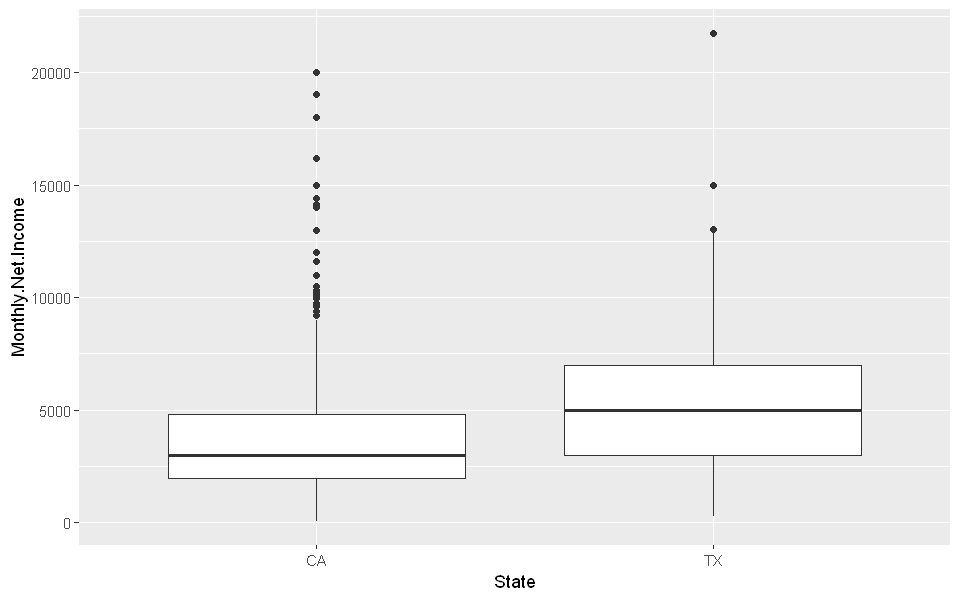

In [464]:
ggplot(train %>% filter(Monthly.Net.Income < 25000), aes(x = State, y = Monthly.Net.Income )) + 
geom_boxplot() 

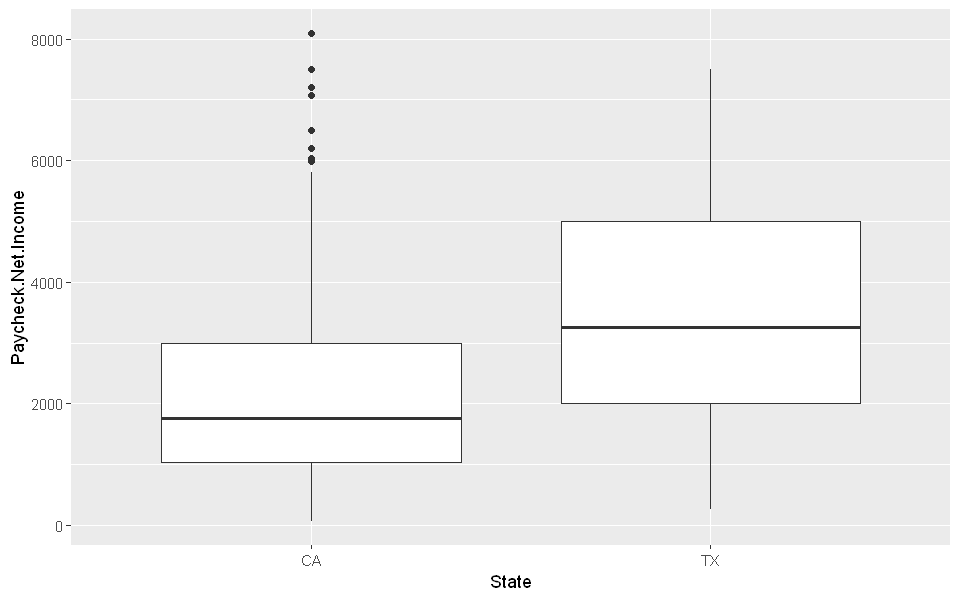

In [465]:
ggplot(train %>% filter(Paycheck.Net.Income < 10000), aes(x = State, y = Paycheck.Net.Income )) + 
geom_boxplot() 

People in Texas earn higher than those in California! What's the effect of this on loan amounts?

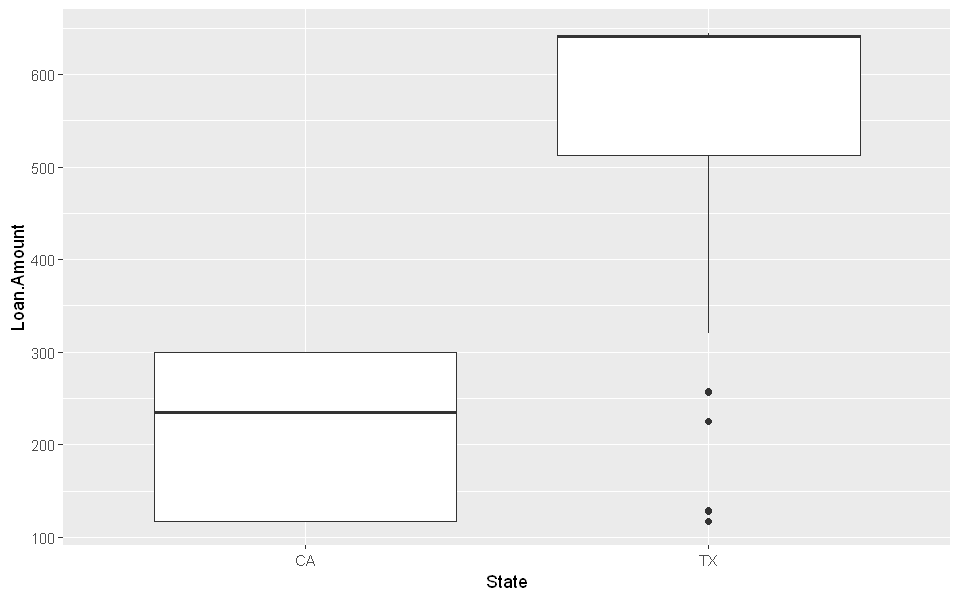

In [466]:
ggplot(train, aes(x = State, y = Loan.Amount )) + 
geom_boxplot() 

Woah! Thats quite a difference. Customers from Texas earn higher than those in California, but have also asked for higher loan amounts than CA residents. This is quite the opposite from what I expected. Intuitively, if a population is earning less, loan amounts should be higher to accomodate the expenses. But, here its the opposite. And, from what I know and based on a google search, cost of living in CA is higher than TX. So, what is happening here? Since, we only have information on 1600 customers, it would be naive to comment based on the limited information. For now, we will leave this as is.


### Loan Amount

Since, the loan amount has limited values, lets bin them and see if we can find any relationship there.

In [467]:
train %>%
mutate(loan_category = case_when(
    Loan.Amount >0 & Loan.Amount <= 100 ~ "0-100",
    Loan.Amount >100 & Loan.Amount <= 200 ~ "100-200",
    Loan.Amount >200 & Loan.Amount <= 350 ~ "200-350",
    Loan.Amount >350 & Loan.Amount <= 450 ~ "350-450",
    Loan.Amount >450 & Loan.Amount <= 550 ~ "450-550",
    Loan.Amount >550 ~ "550+")) %>%
select(loan_category) %>%
table() %>%
prop.table()

.
 100-200  200-350  350-450  450-550     550+ 
0.234375 0.518750 0.039375 0.018125 0.189375 

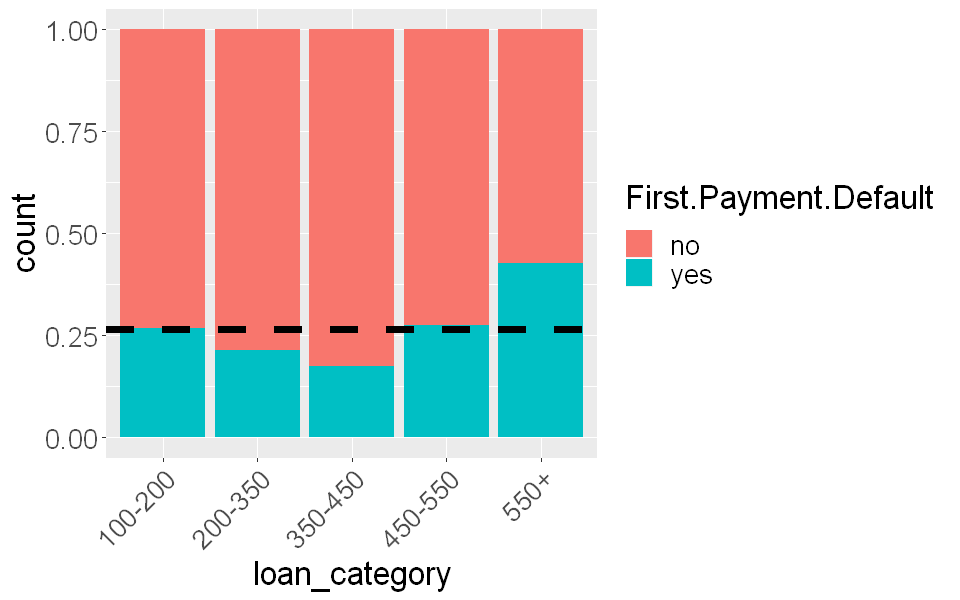

In [468]:
ggplot(data = train %>%
mutate(loan_category = case_when(
    Loan.Amount >0 & Loan.Amount <= 100 ~ "0-100",
    Loan.Amount >100 & Loan.Amount <= 200 ~ "100-200",
    Loan.Amount >200 & Loan.Amount <= 350 ~ "200-350",
    Loan.Amount >350 & Loan.Amount <= 450 ~ "350-450",
    Loan.Amount >450 & Loan.Amount <= 550 ~ "450-550",
    Loan.Amount >550 ~ "550+")), aes(x = loan_category)) +
geom_bar(aes(fill = First.Payment.Default),position = "fill") +
theme(text = element_text(size =20),axis.text.x = element_text(angle = 45,hjust =1)) +
geom_hline(yintercept = 0.265,linetype = "dashed",size = 2)

#### The higher the loan amount asked, likelihood of default goes up! We can use this information to create new variable to classify loan amounts between low/medium/high categories.

In [469]:
train <- train %>%
mutate(loan_category = case_when(
    Loan.Amount >0 & Loan.Amount <= 200 ~ "low",
    Loan.Amount >200 & Loan.Amount <= 350 ~ "medium",
    Loan.Amount >350 ~ "high")) 

In [470]:
#Lets create these changes in our clean dataset as well
clean_data$time.to.review <- difftime(clean_data$Loan.Funded.Date, as_date(clean_data$Time.of.Application) ,units = "days")
clean_data$time.to.pay <- difftime(clean_data$Loan.Due.Date,clean_data$Loan.Funded.Date ,units = "days")
clean_data <- clean_data %>%
mutate(loan_category = case_when(
    Loan.Amount >0 & Loan.Amount <= 200 ~ "low",
    Loan.Amount >200 & Loan.Amount <= 350 ~ "medium",
    Loan.Amount >350 ~ "high")) 
#Lets also drop the date columns as we wont be using them for modelling
clean_data$Time.of.Application <- NULL
clean_data$Loan.Funded.Date <- NULL
clean_data$Loan.Due.Date <- NULL

In [471]:
clean_data$time.to.review <- as.numeric(clean_data$time.to.review)
clean_data$time.to.pay <- as.numeric(clean_data$time.to.pay)

In [472]:
#sanity check
str(clean_data)

'data.frame':	2000 obs. of  12 variables:
 $ State                : Factor w/ 2 levels "CA","TX": 1 2 1 1 1 2 1 1 1 2 ...
 $ Monthly.Net.Income   : num  2000 3500 3000 1500 2392 ...
 $ Paycheck.Net.Income  : num  2000 3500 3000 1500 598 ...
 $ Rent.or.Own          : Factor w/ 2 levels "O","R": 2 2 2 2 2 2 2 2 2 2 ...
 $ Months.at.Residence  : int  12 60 0 12 130 12 36 37 60 24 ...
 $ Bank.Account.Months  : int  6 60 6 6 36 12 12 36 60 15 ...
 $ Pay.Cycle            : Factor w/ 4 levels "BiMonthly","BiWeekly",..: 3 3 3 3 4 2 2 1 2 2 ...
 $ Loan.Amount          : num  300 642 118 118 300 ...
 $ First.Payment.Default: Factor w/ 2 levels "no","yes": 1 1 2 1 1 1 2 1 2 2 ...
 $ time.to.review       : num  0 0 0 0 0 2 2 1 0 0 ...
 $ time.to.pay          : num  14 14 30 31 10 11 9 9 15 10 ...
 $ loan_category        : chr  "medium" "high" "low" "low" ...


# Correlation

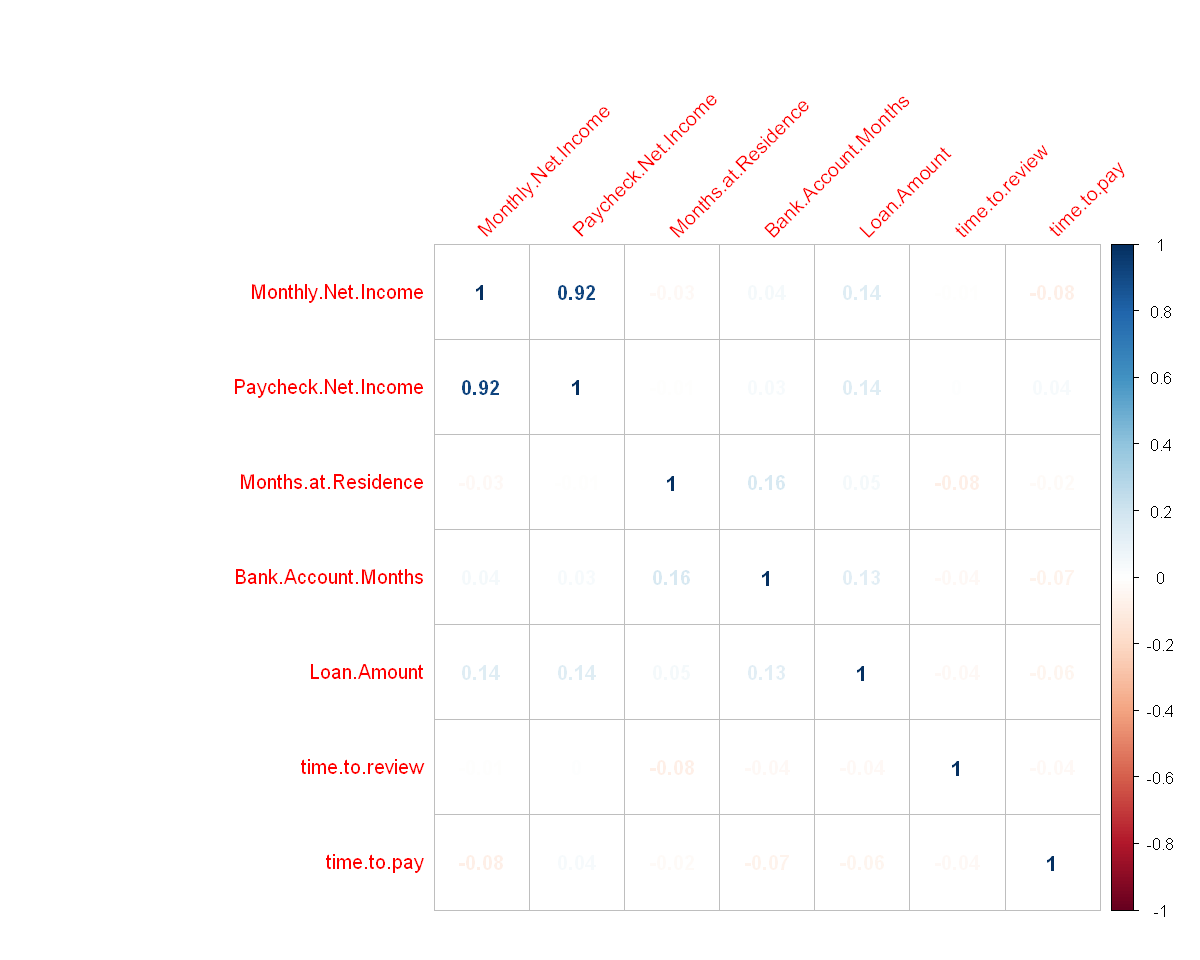

In [473]:
options(repr.plot.width = 10, repr.plot.height = 8)
corr <- cor(clean_data %>% select(c(numerical,time.to.review,time.to.pay)))
corrplot(corr,tl.srt =45,method = "number")

As expected, Paycheck Net Income and Monthly Net Income are highly correlated. Using Monthly Net Income makes more sense, as it also includes the Paycheck Income, and we dont lose any information.

In [474]:
clean_data$Paycheck.Net.Income <- NULL

# Data Preparation

In [475]:
#sanity check
str(clean_data)

'data.frame':	2000 obs. of  11 variables:
 $ State                : Factor w/ 2 levels "CA","TX": 1 2 1 1 1 2 1 1 1 2 ...
 $ Monthly.Net.Income   : num  2000 3500 3000 1500 2392 ...
 $ Rent.or.Own          : Factor w/ 2 levels "O","R": 2 2 2 2 2 2 2 2 2 2 ...
 $ Months.at.Residence  : int  12 60 0 12 130 12 36 37 60 24 ...
 $ Bank.Account.Months  : int  6 60 6 6 36 12 12 36 60 15 ...
 $ Pay.Cycle            : Factor w/ 4 levels "BiMonthly","BiWeekly",..: 3 3 3 3 4 2 2 1 2 2 ...
 $ Loan.Amount          : num  300 642 118 118 300 ...
 $ First.Payment.Default: Factor w/ 2 levels "no","yes": 1 1 2 1 1 1 2 1 2 2 ...
 $ time.to.review       : num  0 0 0 0 0 2 2 1 0 0 ...
 $ time.to.pay          : num  14 14 30 31 10 11 9 9 15 10 ...
 $ loan_category        : chr  "medium" "high" "low" "low" ...


- Creating Dummy Variables

In [476]:
clean_data <- dummy_cols(clean_data,select_columns = c("State","Rent.or.Own","Pay.Cycle","loan_category"),remove_first_dummy = TRUE)
clean_data <- clean_data %>%
            select(-c("State","Rent.or.Own","Pay.Cycle","loan_category"))
head(clean_data)

,Monthly.Net.Income,Months.at.Residence,Bank.Account.Months,Loan.Amount,First.Payment.Default,time.to.review,time.to.pay,State_TX,Rent.or.Own_O,Pay.Cycle_Weekly,Pay.Cycle_BiWeekly,Pay.Cycle_BiMonthly,loan_category_high,loan_category_low
,<dbl>,<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2000,12,6,300.00,no,0,14,0,0,0,0,0,0,0
2,3500,60,60,641.91,no,0,14,1,0,0,0,0,1,0
3,3000,0,6,117.65,yes,0,30,0,0,0,0,0,0,1
4,1500,12,6,117.65,no,0,31,0,0,0,0,0,0,1
5,2392,130,36,300.00,no,0,10,0,0,1,0,0,0,0
6,5000,12,12,385.06,no,2,11,1,0,0,1,0,1,0


In [477]:
#Dividing into train, test and validation splits
test <- clean_data %>%
        filter(is.na(First.Payment.Default))

In [478]:
train <- clean_data %>%
        filter(!is.na(First.Payment.Default))
#Scaling the numerical variables
train <- train %>% 
        mutate_at(scale,.vars = c('Monthly.Net.Income','Months.at.Residence','Bank.Account.Months','Loan.Amount','time.to.review','time.to.pay'))

In [479]:
set.seed(123)
ind <- createDataPartition(train$First.Payment.Default, p =0.8)[[1]]
training_set <- train[ind,]
validation <- train[-ind,]

## PCA Analysis

In [480]:
cbind(train %>% select(- First.Payment.Default) %>% colnames(),prcomp(train %>% select(- First.Payment.Default))[[1]])

Monthly.Net.Income,1.24463074870761
Months.at.Residence,1.08511290980947
Bank.Account.Months,1.04066338783192
Loan.Amount,0.986581582678181
time.to.review,0.929152770146734
time.to.pay,0.896213720722089
State_TX,0.492020665158272
Rent.or.Own_O,0.376567589474993
Pay.Cycle_Weekly,0.307558551561914
Pay.Cycle_BiWeekly,0.291646842526362
Pay.Cycle_BiMonthly,0.190765441590605


The variance is distributed among all the 13 variables. PCA isn't too helpful here.

# Modelling

### Model Comparison: Evaluation Metrics 

Since, the target is to identify defaulting customers correctly, we need to focus more on getting True Positive correct (High TPR). Assuming the company wont approve applications for flagged defaulting applicants, False Negatives are something we want to reduce as much as possible. In case of False Negative, the company will suffer costs of non-payment. We want to reduce this as much possible. False Positives, in this case, would mean we flagged an applicant for default incorrectly. In this case, we will lose the applicant for any business.

* Since, our primary objective is to maximize True Positives and minimize False Positives, we will look at metrics ROC-AUC and confusion matrix.

## Model Comparison Metrics

In [720]:
#Roc-curve
roc_curve_plot <- function(probabilities, new_data, target,model_name){
    temp <- as.vector(unlist(new_data[target]))
    temp <- as.factor(temp)
    ROCit_obj <- rocit(score=probabilities,class=temp)
    cat("Area Under Curve for",model_name,":",round(ROCit_obj$AUC,2))
    plot(ROCit_obj,values = TRUE,main = "ROC curve")
}

#cross-validation
control <- trainControl(method = "cv",number = 10,classProbs = TRUE,summaryFunction = twoClassSummary)

### Logistic Regression

In [699]:
log_model <- train(form = First.Payment.Default ~ ., data = training_set, method = "glm",family = "binomial", trControl = control,metric = "ROC")
summary(log_model)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5158  -0.7802  -0.6739   1.2396   2.2037  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -1.352383   0.181440  -7.454 9.08e-14 ***
Monthly.Net.Income   0.193881   0.115255   1.682  0.09253 .  
Months.at.Residence -0.036062   0.074971  -0.481  0.63051    
Bank.Account.Months -0.139184   0.083082  -1.675  0.09388 .  
Loan.Amount          0.476282   0.214174   2.224  0.02616 *  
time.to.review       0.187255   0.057676   3.247  0.00117 ** 
time.to.pay          0.114458   0.082861   1.381  0.16718    
State_TX            -1.013194   0.549747  -1.843  0.06533 .  
Rent.or.Own_O        0.158160   0.214815   0.736  0.46157    
Pay.Cycle_Weekly     0.025212   0.333262   0.076  0.93970    
Pay.Cycle_BiWeekly   0.327117   0.187052   1.749  0.08033 .  
Pay.Cycle_BiMonthly  0.005785   0.260107   0.022  0.98226    
loan_category_high   0.888595   0.679222   1.308  0.1

Area Under Curve for Logistic Regression : 0.56

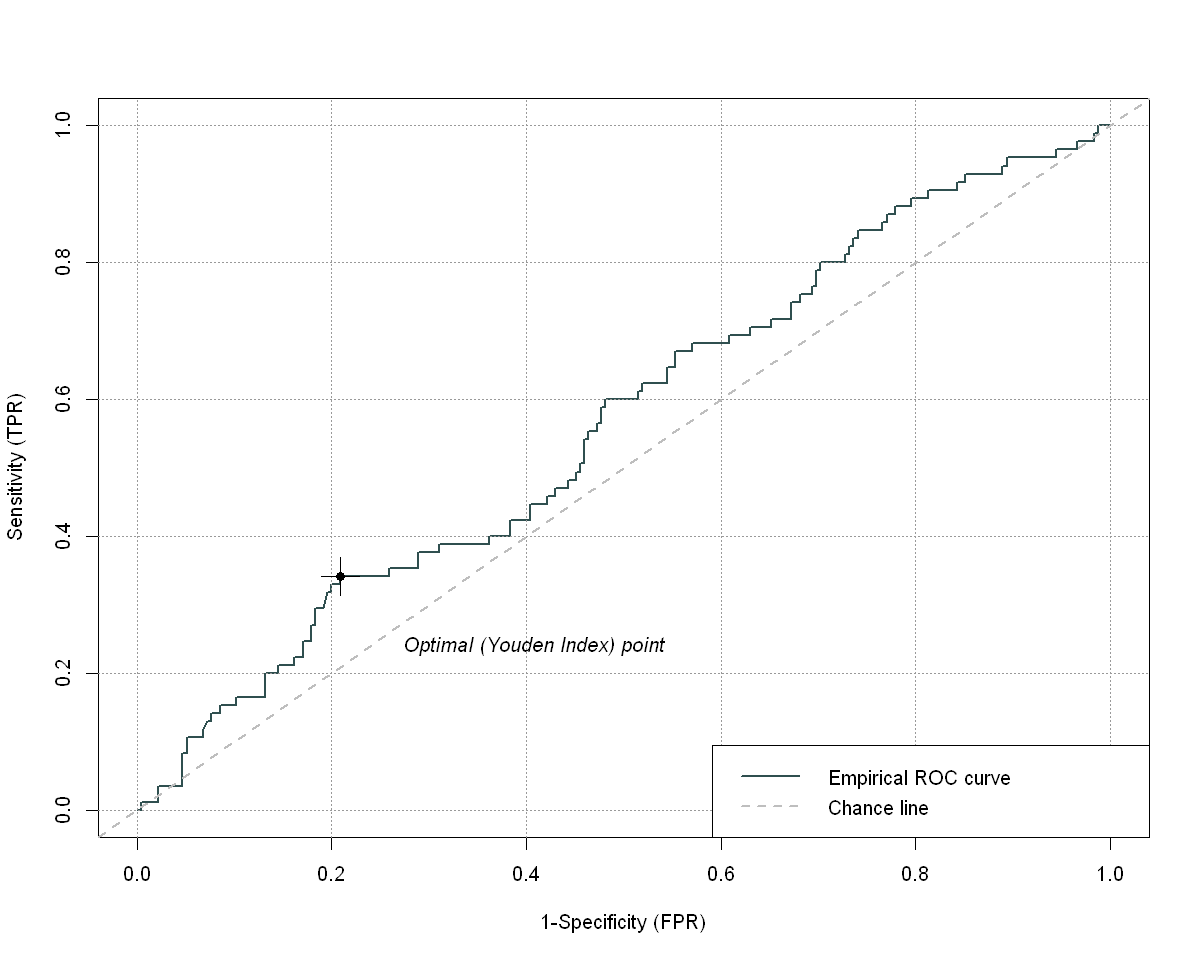

In [721]:
prob <- predict(log_model, type = "prob", newdata = new_data)[[2]]
roc_curve_plot(prob,validation,"First.Payment.Default","Logistic Regression")

## Decision Tree

In [704]:
dtree <- train(form = First.Payment.Default ~ ., data = training_set, method = "rpart", trControl = control, metric = "ROC")

Area Under Curve for Decision Tree : 0.57

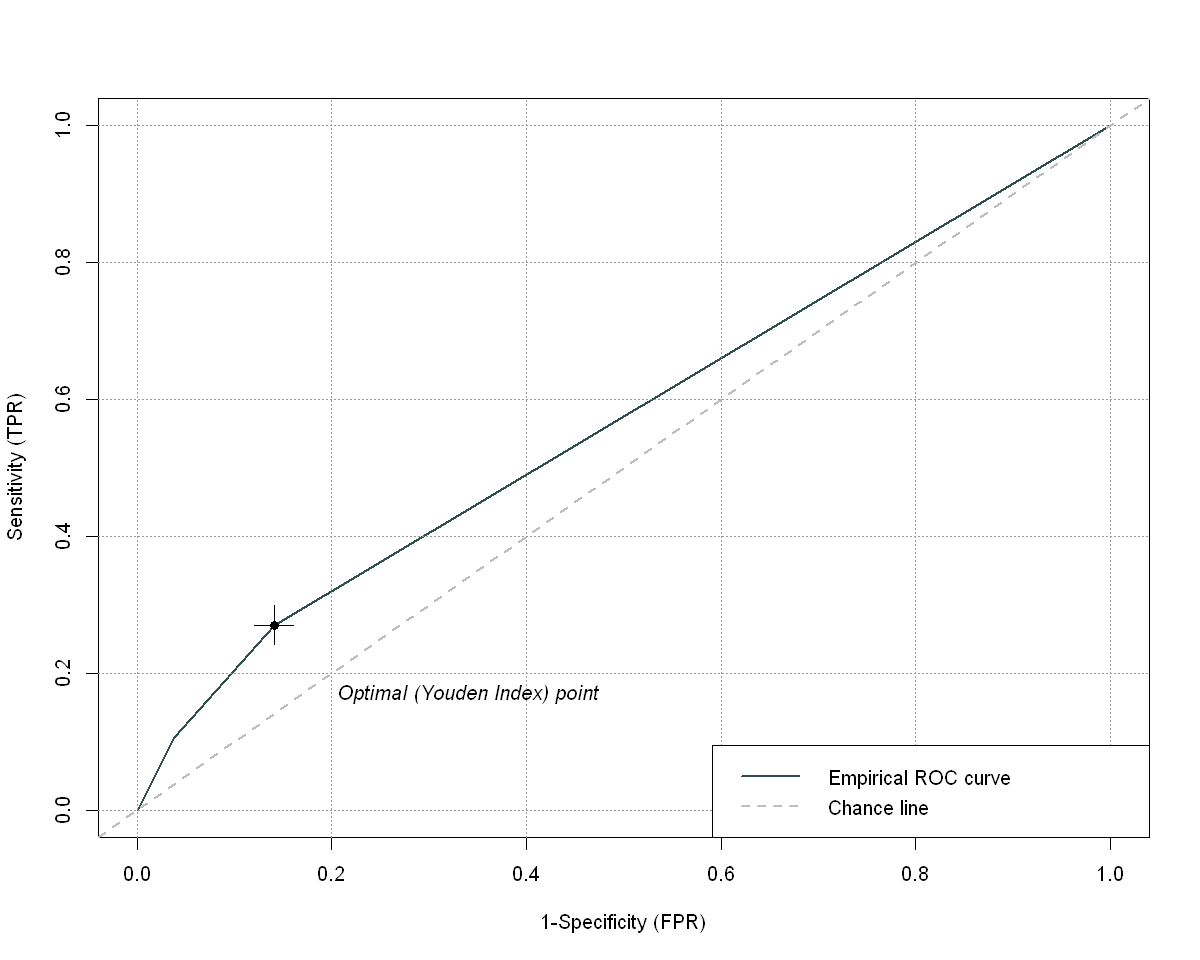

In [744]:
prob <- predict(dtree, type = "prob", newdata = validation)[[2]]
roc_curve_plot(prob,validation,"First.Payment.Default","Decision Tree")

## Random Forest

In [724]:
rf <- train(form = First.Payment.Default ~ ., data = training_set, method = "rf", trControl = control, metric = "ROC")

Area Under Curve for Random Forest : 0.54

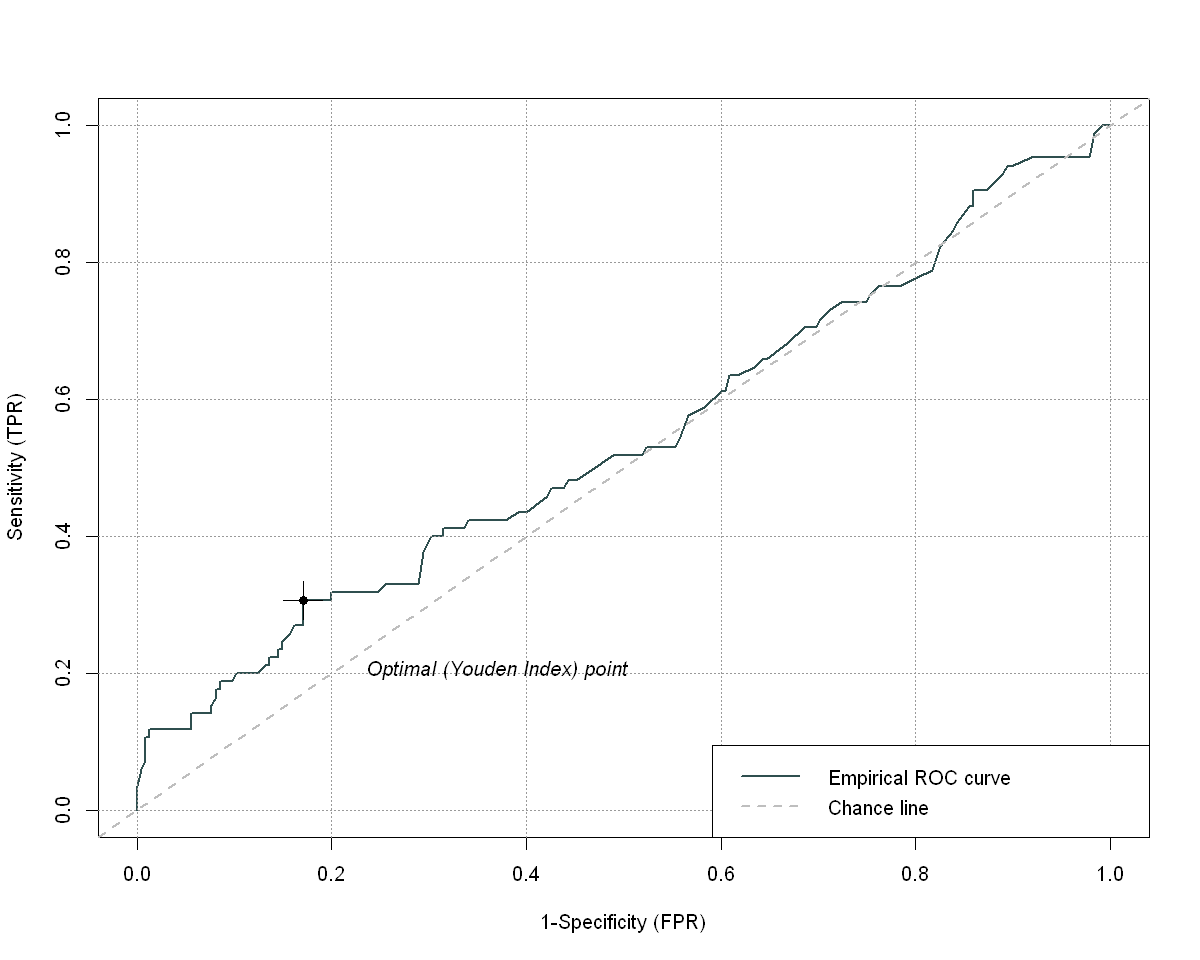

In [742]:
prob <- predict(rf, type = "prob", newdata = validation)[[2]]
roc_curve_plot(prob,validation,"First.Payment.Default","Random Forest")

## Ada-Boost

In [729]:
ada <- train(form = First.Payment.Default ~ ., data = training_set, method = "adaboost", trControl = control, metric = "ROC")

Area Under Curve for Ada Boost : 0.54

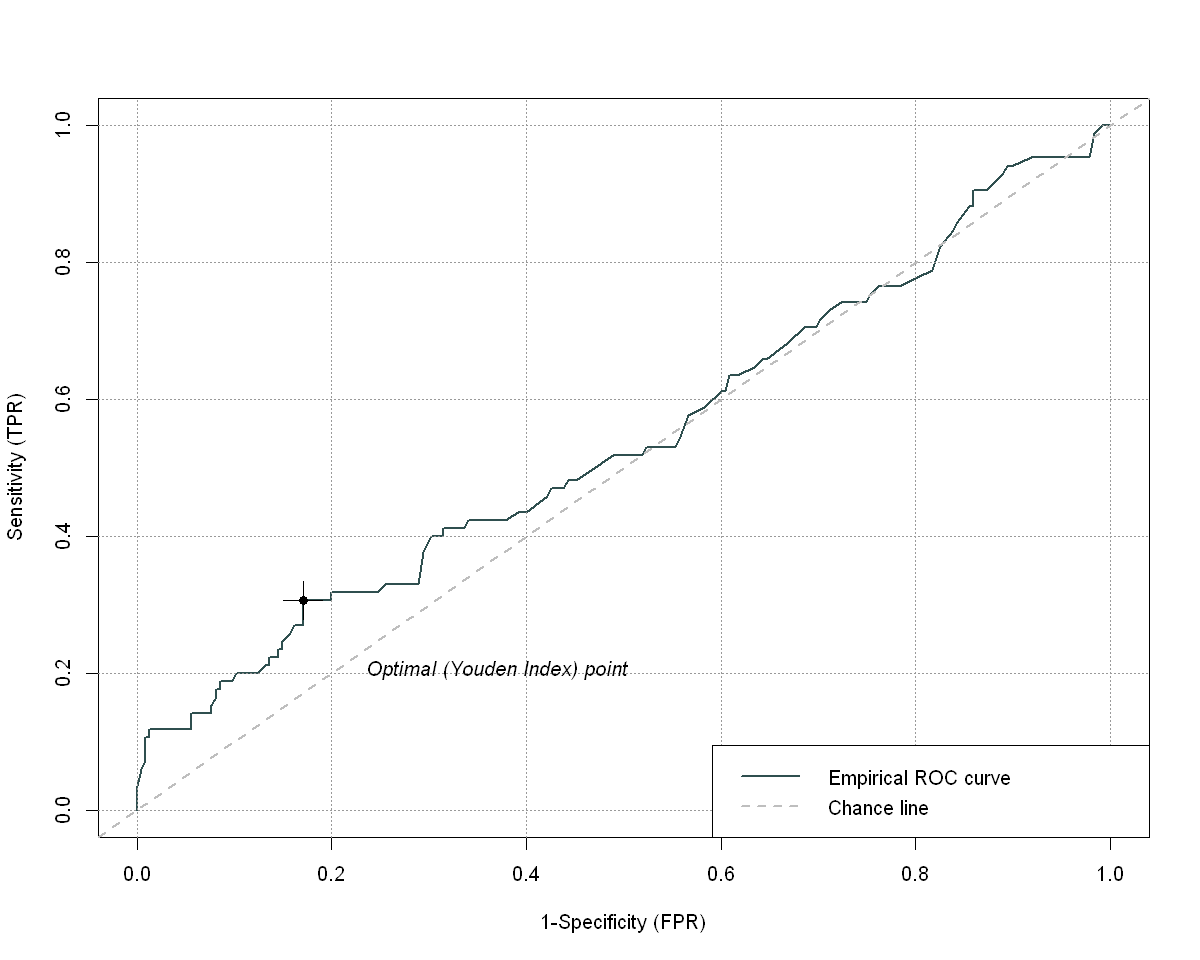

In [743]:
prob <- predict(rf, type = "prob", newdata = validation)[[2]]
roc_curve_plot(prob,validation,"First.Payment.Default","Ada Boost")

- All the algorithms are performing disastrous results. There is no point tuning the parameters at this stage. Our dataset contains a big class imbalance issue. It would be best to balance the classes and then repeat the above exercise.

## Balancing the classes

There are 3 ways we can balance the classes out - under-sample, over-sample and SMOTE technique. Under-sampling means losing already limited training data. Out of the other two, I will use the SMOTE technique to balance the classes.

### SMOTE technique

In [782]:
train_smote <- DMwR::SMOTE(form = First.Payment.Default ~ ., data = training_set,perc.over = 200,perc.under = 150) 
table(train_smote$First.Payment.Default)


  no  yes 
1020 1020 

### Random Forest

Area Under Curve for Smote: Random Forest : 0.55

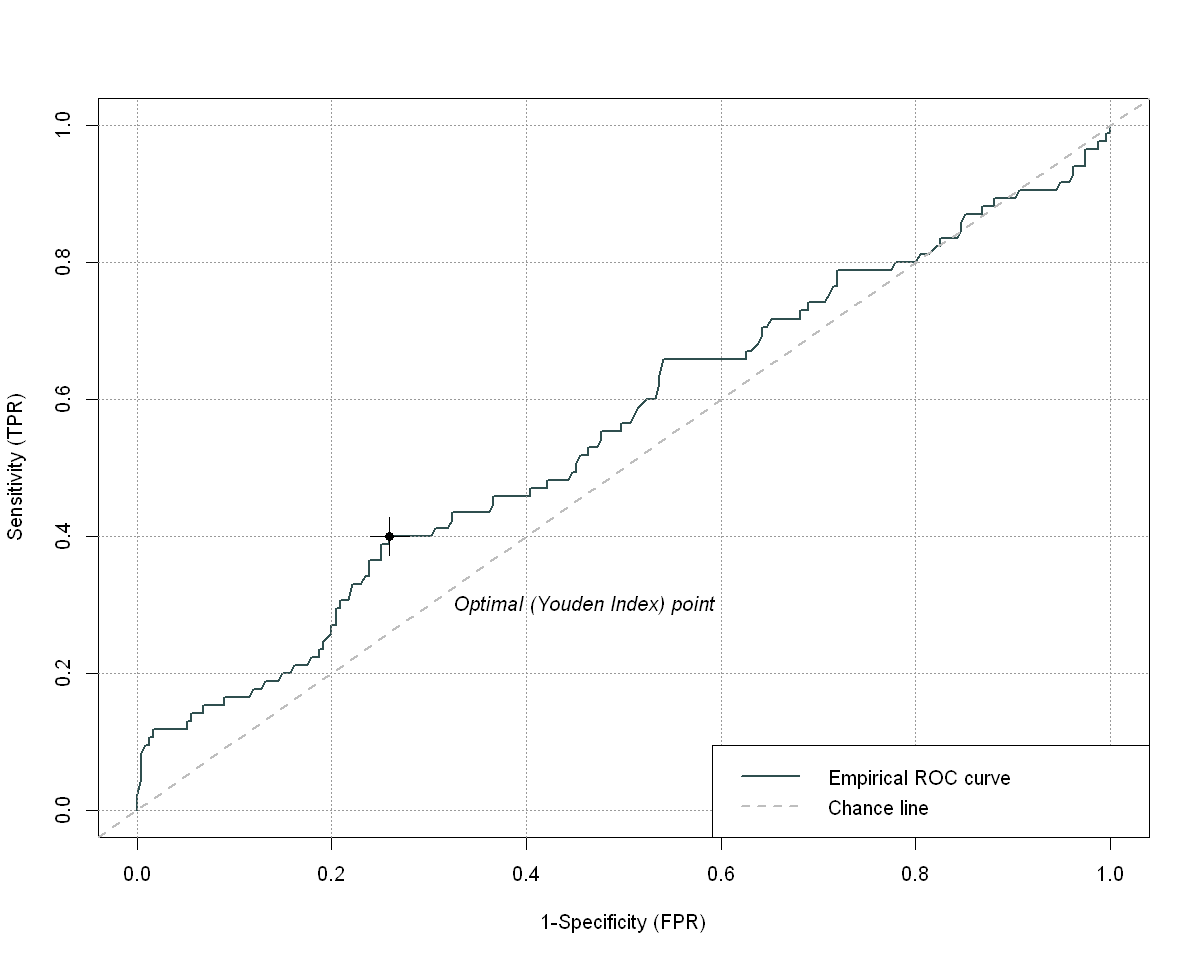

In [783]:
rf_smote <- train(form = First.Payment.Default ~ ., data = train_smote, method = "rf", trControl = control, metric = "ROC")
prob <- predict(rf_smote, type = "prob", newdata = validation)[[2]]
roc_curve_plot(prob,validation,"First.Payment.Default","Smote: Random Forest")

### Ada-Boost

Area Under Curve for Smote: Ada Boost : 0.55

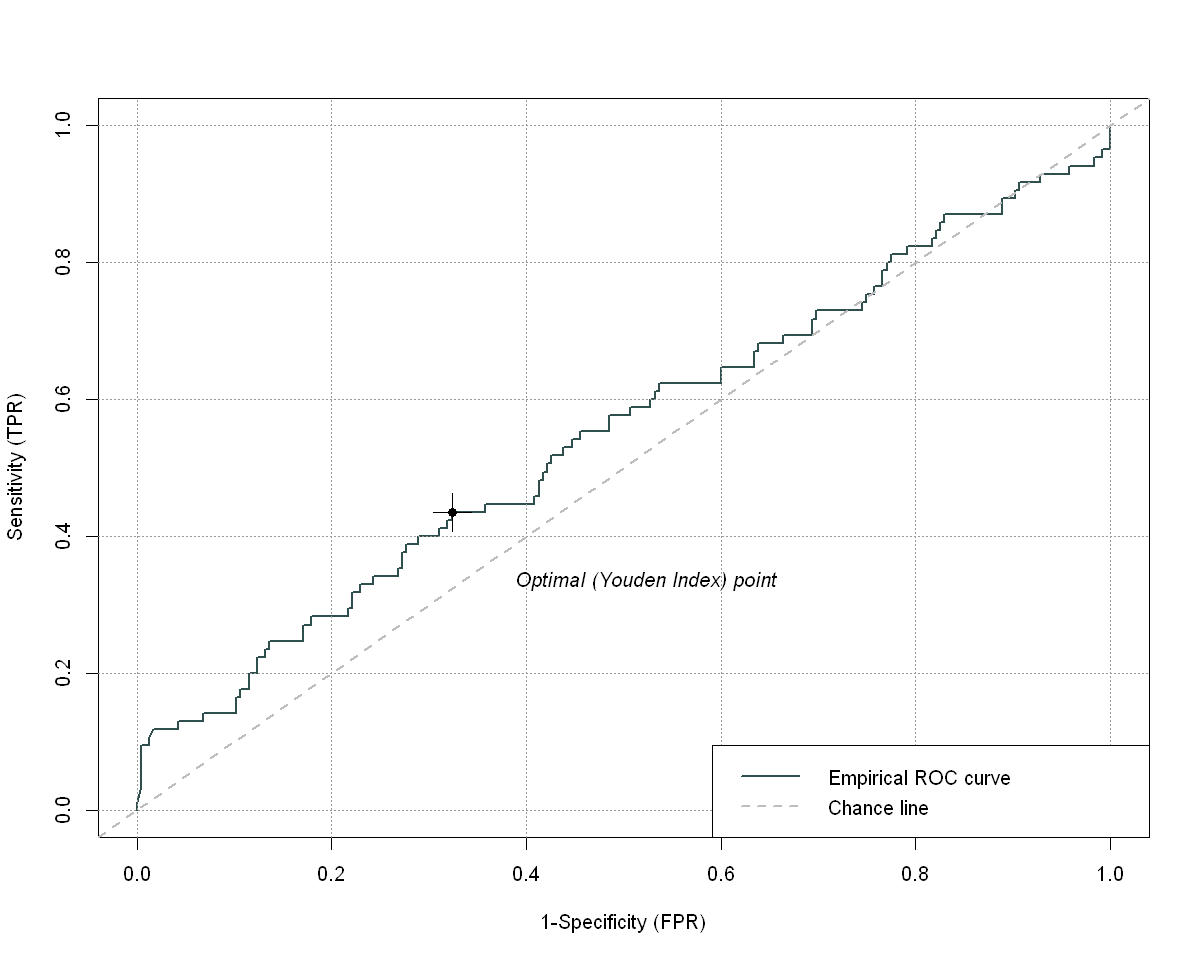

In [784]:
ada_smote <- train(form = First.Payment.Default ~ ., data = train_smote, method = "adaboost", trControl = control, metric = "ROC")
prob <- predict(ada_smote, type = "prob", newdata = validation)[[2]]
roc_curve_plot(prob,validation,"First.Payment.Default","Smote: Ada Boost")

### Over-sampling

In [795]:
train_over_sample <- ovun.sample(First.Payment.Default ~ ., data = training_set,method = "over")$data
prop.table(table(train_over_sample$First.Payment.Default))


       no       yes 
0.4895833 0.5104167 

#### Random Forest

Area Under Curve for Over-Sampling: Random Forest : 0.55

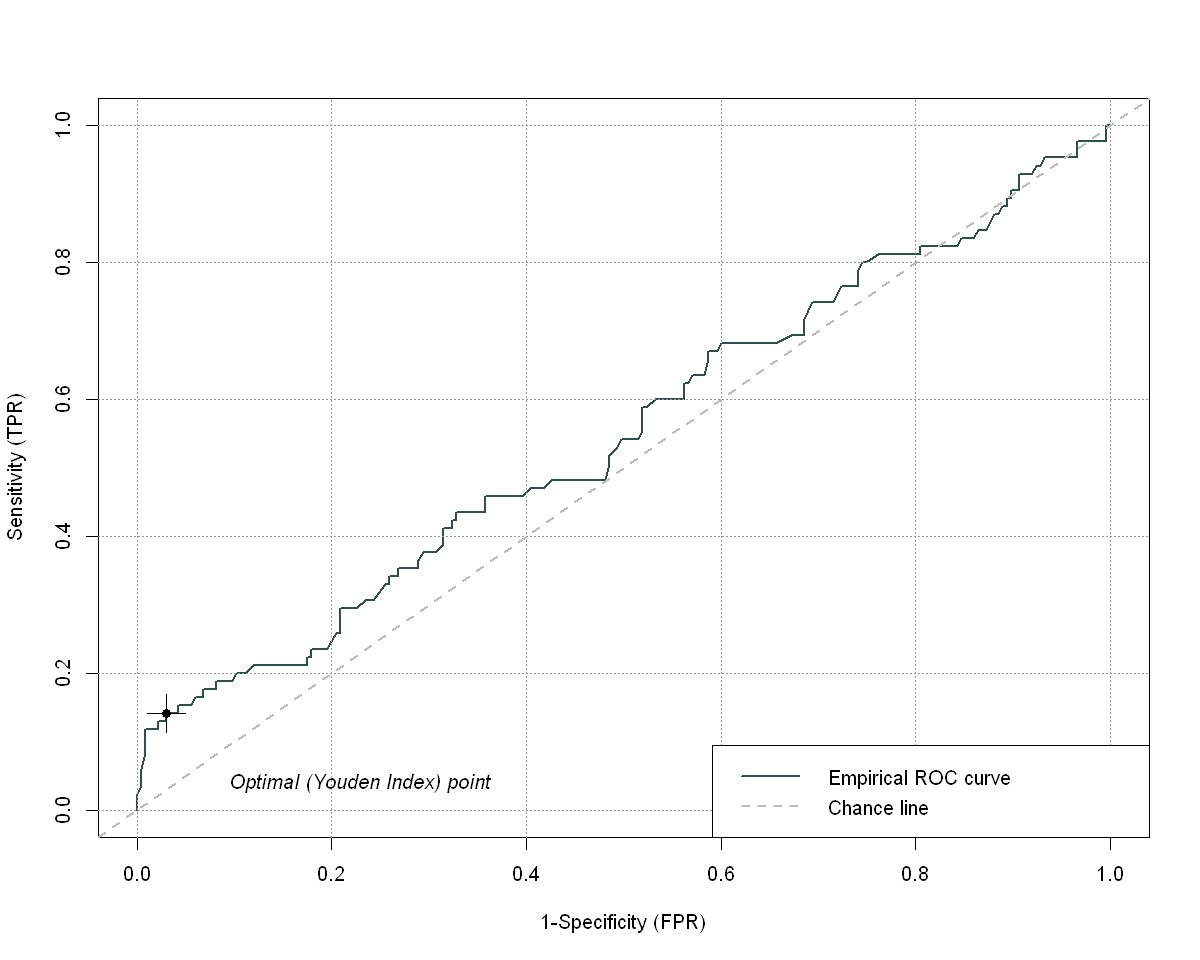

In [796]:
rf_over <- train(form = First.Payment.Default ~ ., data = train_over_sample, method = "rf", trControl = control, metric = "ROC")
prob <- predict(rf_over, type = "prob", newdata = validation)[[2]]
roc_curve_plot(prob,validation,"First.Payment.Default","Over-Sampling: Random Forest")

### Ada-Boost

Area Under Curve for Over-Sampling: Ada-Boost : 0.55

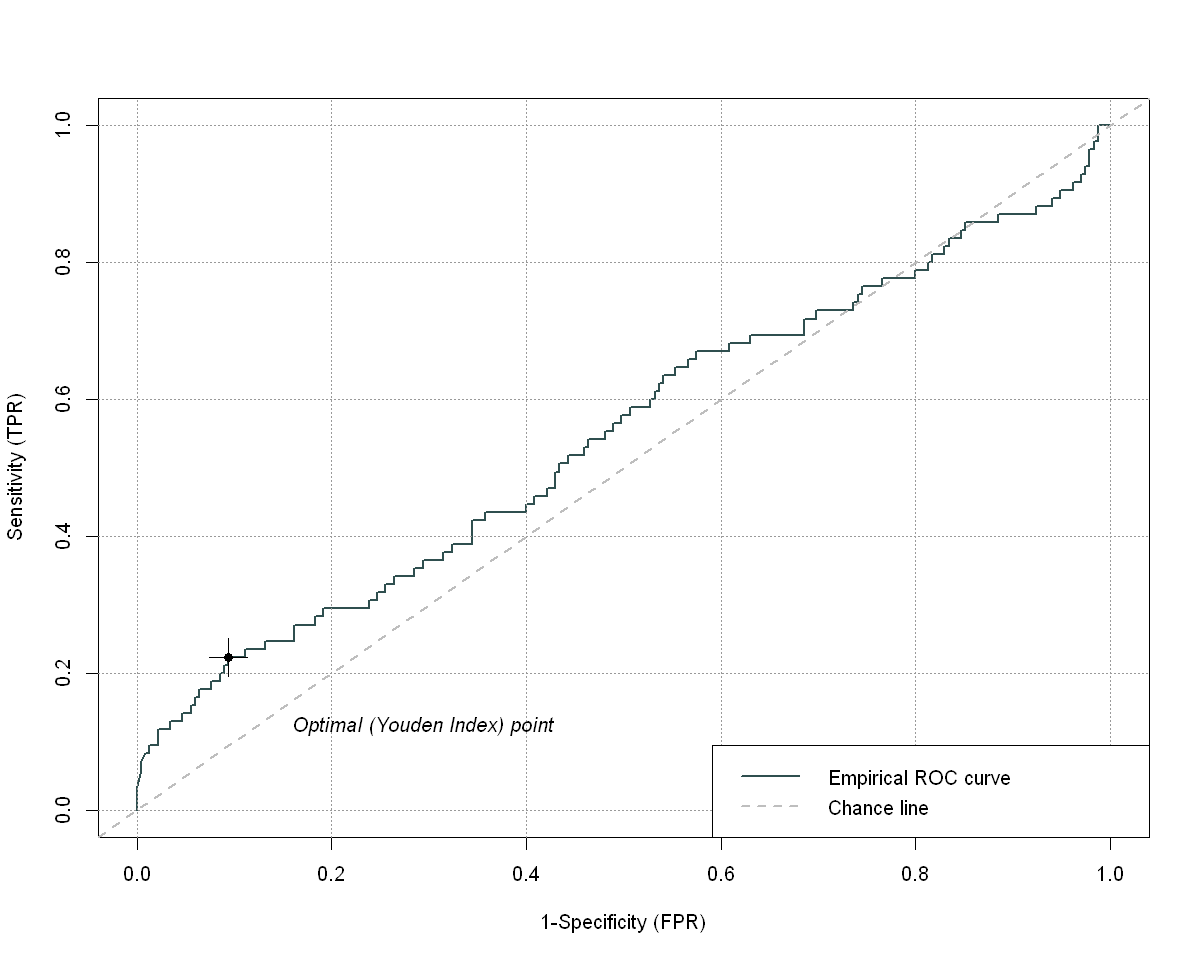

In [797]:
ada_over <- train(form = First.Payment.Default ~ ., data = train_over_sample, method = "adaboost", trControl = control, metric = "ROC")
prob <- predict(ada_over, type = "prob", newdata = validation)[[2]]
roc_curve_plot(prob,validation,"First.Payment.Default","Over-Sampling: Ada-Boost")

All these are very poor classifiers. We tried balancing the classes, but since we are limited on the training set, and could not derive any useful insights from the available data, we have to make the best use of resources. Lets select the SMOTE'd dataset and tune the hyper-paramters of random forest model and see whether we can improve its performance any further.

# Hyper-tune parameters

#### Random Forest

There are a number of paramters we can hyper-tune:
    1. mtry - number of variables randomly sampled to be used at each decision split
    2. ntree - number of trees to grow

* Tree level paramters:

    3. max_depth - maximum depth of each tree
    4. node_size
    5. sample size
    6. maxnodes
    
We will tune the top 2 paramters, as they are the most important ones, and are likely to have the biggest impact on results.

### Random Search

In [814]:
#tuning mtry
control <- trainControl(method="cv", number=10, search="random",classProbs = TRUE,summaryFunction = twoClassSummary)
mtry <- sqrt(ncol(train_smote)-1)
rf_random <- train(form = First.Payment.Default~., data=train_smote, method="rf", metric="ROC",trControl=control,tuneLength = 15)

Random Forest 

2040 samples
  13 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1836, 1836, 1836, 1836, 1836, 1836, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   1    0.7571799  0.6568627  0.6970588
   3    0.9394127  0.8823529  0.8450980
   4    0.9464004  0.9029412  0.8539216
   5    0.9458285  0.8950980  0.8519608
   7    0.9429979  0.8960784  0.8480392
   8    0.9407439  0.8882353  0.8421569
  11    0.9360054  0.8921569  0.8411765
  12    0.9342609  0.8862745  0.8333333

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 4.


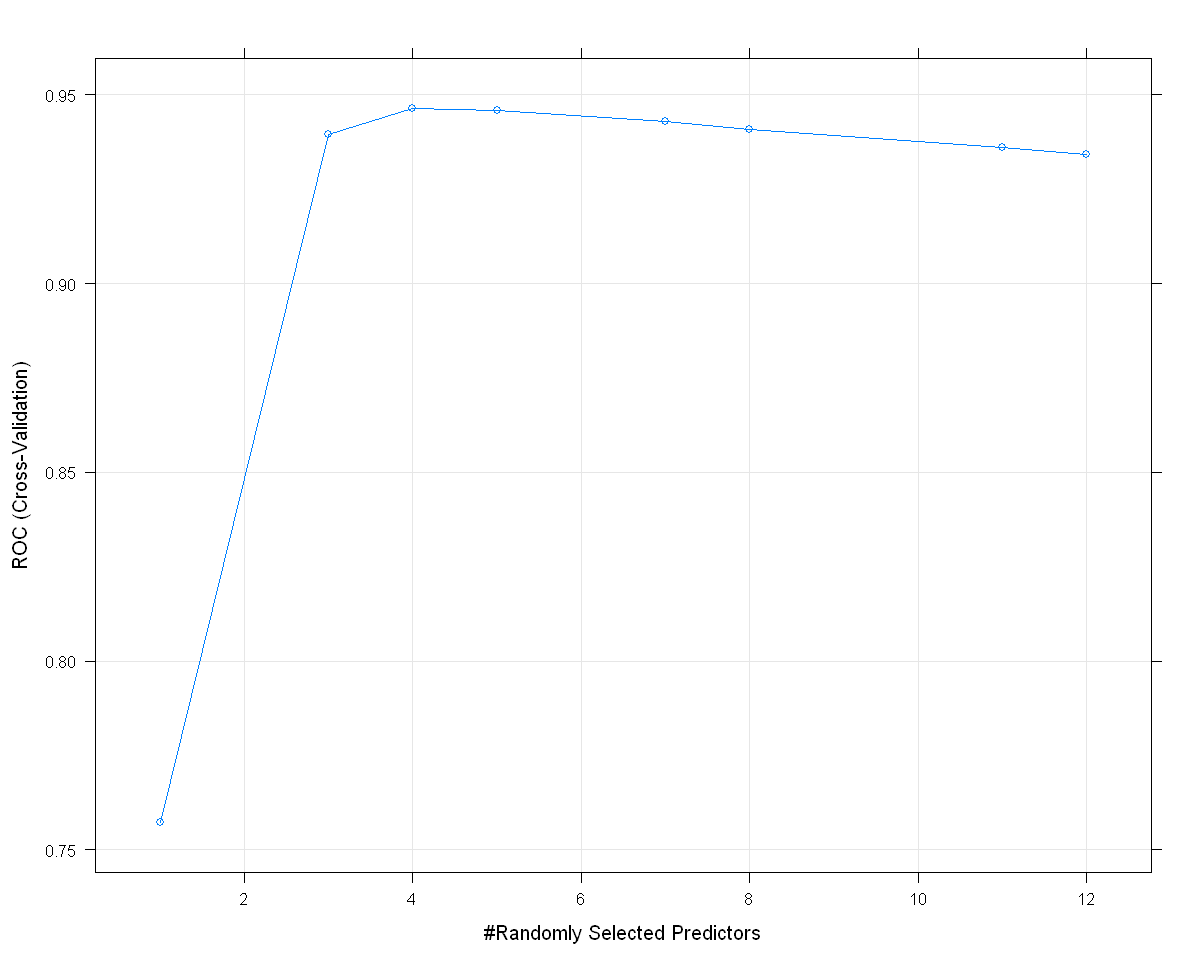

In [815]:
print(rf_random)
plot(rf_random)

### Grid Search

In [818]:
control <- trainControl(method="cv", number=10, search="grid",classProbs = TRUE, summaryFunction = twoClassSummary)
tunegrid <- expand.grid(.mtry=c(1:10))
rf_gridsearch <- train(First.Payment.Default~., data=train_smote, method="rf", metric="ROC", tuneGrid=tunegrid, trControl=control)

Random Forest 

2040 samples
  13 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1836, 1836, 1836, 1836, 1836, 1836, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   1    0.7579104  0.6568627  0.7000000
   2    0.8997693  0.8147059  0.8156863
   3    0.9413639  0.8794118  0.8656863
   4    0.9461073  0.8960784  0.8558824
   5    0.9467224  0.8931373  0.8558824
   6    0.9460736  0.8931373  0.8539216
   7    0.9442570  0.8931373  0.8490196
   8    0.9429402  0.8921569  0.8470588
   9    0.9414937  0.8892157  0.8431373
  10    0.9397155  0.8901961  0.8470588

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 5.


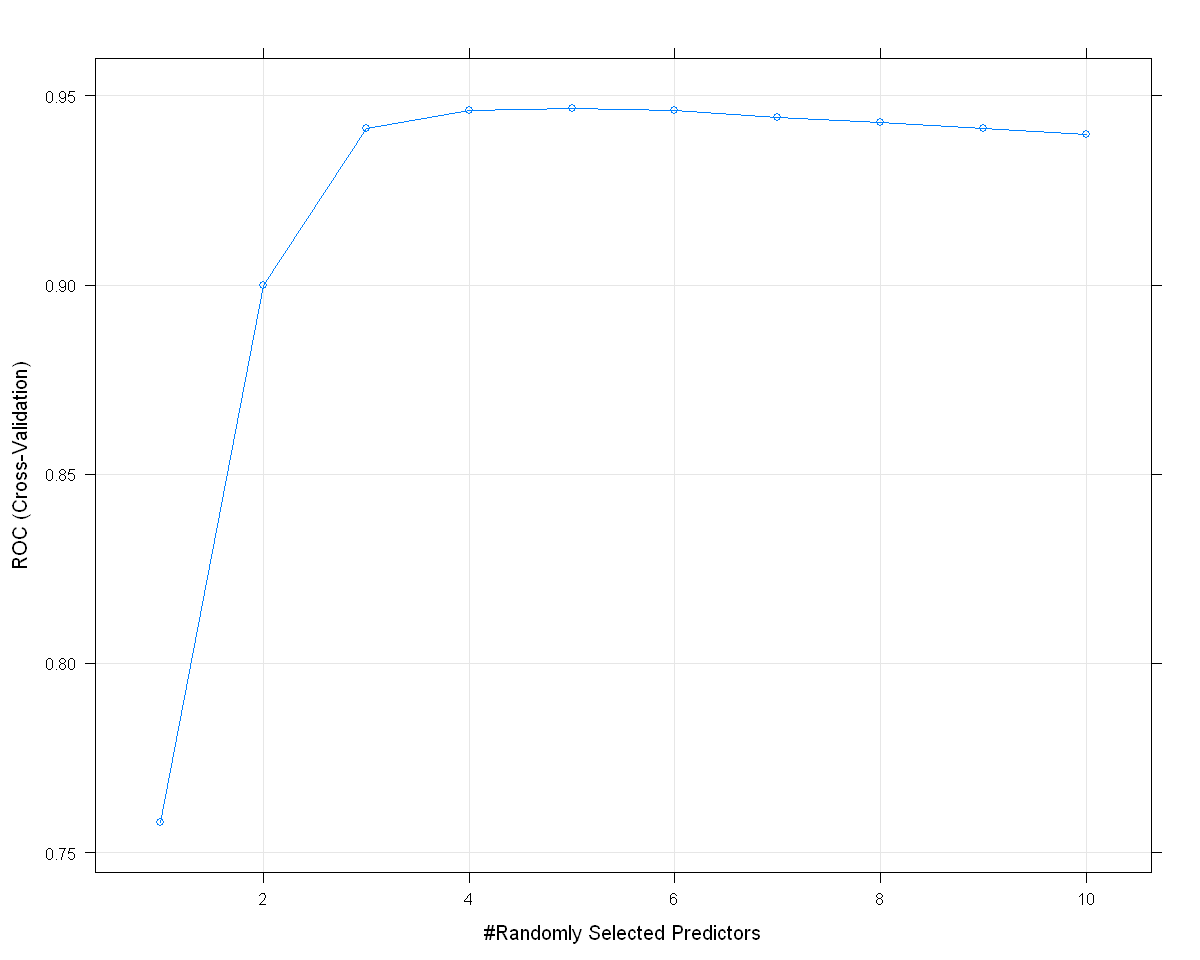

In [819]:
print(rf_gridsearch)
plot(rf_gridsearch)

In [822]:
#tuning ntree
control <- trainControl(method="cv", number=10, search="grid",classProbs = TRUE, summaryFunction = twoClassSummary)
modellist <- list()
for (ntree in c(1000, 1500, 2000, 2500)) {
    fit <- train(First.Payment.Default~., data=train_smote, method="rf", metric="ROC", trControl=control, ntree=ntree)
    key <- toString(ntree)
    modellist[[key]] <- fit
}
# compare results
results <- resamples(modellist)


Call:
summary.resamples(object = results)

Models: 1000, 1500, 2000, 2500 
Number of resamples: 10 

ROC 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
1000 0.9171953 0.9250048 0.9436034 0.9425654 0.9547410 0.9755383    0
1500 0.8839389 0.9356017 0.9465110 0.9395713 0.9547890 0.9627547    0
2000 0.9267589 0.9334150 0.9458622 0.9446511 0.9522299 0.9699635    0
2500 0.9059496 0.9314687 0.9398308 0.9392109 0.9501514 0.9618416    0

Sens 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
1000 0.8039216 0.8823529 0.8970588 0.8921569 0.9191176 0.9411765    0
1500 0.8039216 0.8602941 0.8970588 0.8901961 0.9264706 0.9411765    0
2000 0.8627451 0.8823529 0.8872549 0.8901961 0.8995098 0.9313725    0
2500 0.8039216 0.8431373 0.8872549 0.8774510 0.9093137 0.9313725    0

Spec 
          Min.   1st Qu.    Median      Mean  3rd Qu.      Max. NA's
1000 0.8039216 0.8259804 0.8431373 0.8490196 0.877451 0.8921569    0
1500 0.7745098 0.8284314 0.8627451 0.8519

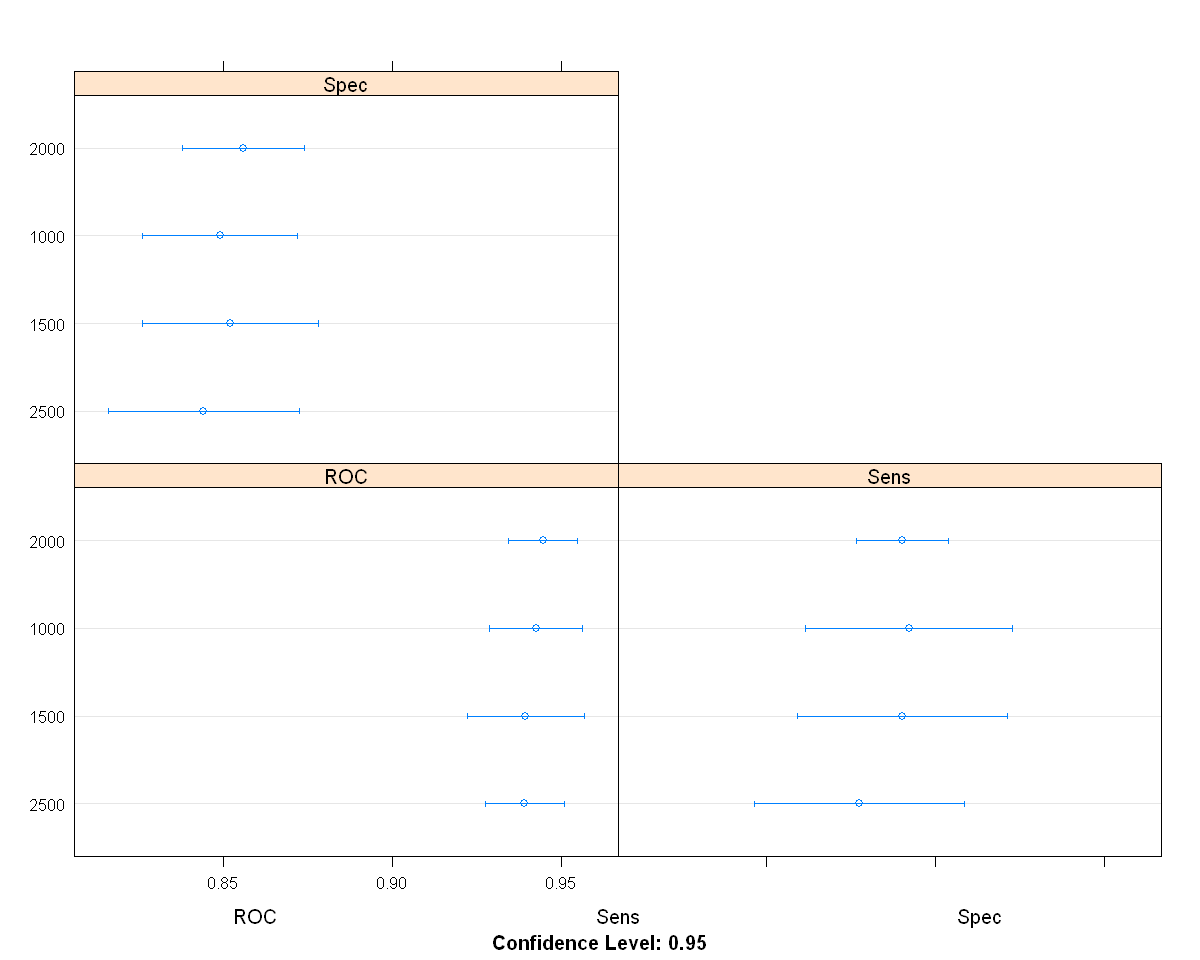

In [824]:
summary(results)
dotplot(results)

Our final values for paramters are ntree = 2000 and mtry = 5

In [828]:
rf_tuned <- randomForest(First.Payment.Default ~., data = train_smote, mtry = 5,ntree = 2000)

In [829]:
rf_tuned


Call:
 randomForest(formula = First.Payment.Default ~ ., data = train_smote,      mtry = 5, ntree = 2000) 
               Type of random forest: classification
                     Number of trees: 2000
No. of variables tried at each split: 5

        OOB estimate of  error rate: 11.67%
Confusion matrix:
     no yes class.error
no  919 101  0.09901961
yes 137 883  0.13431373

Area Under Curve for SMOTE: Tuned Random Forest : 0.55

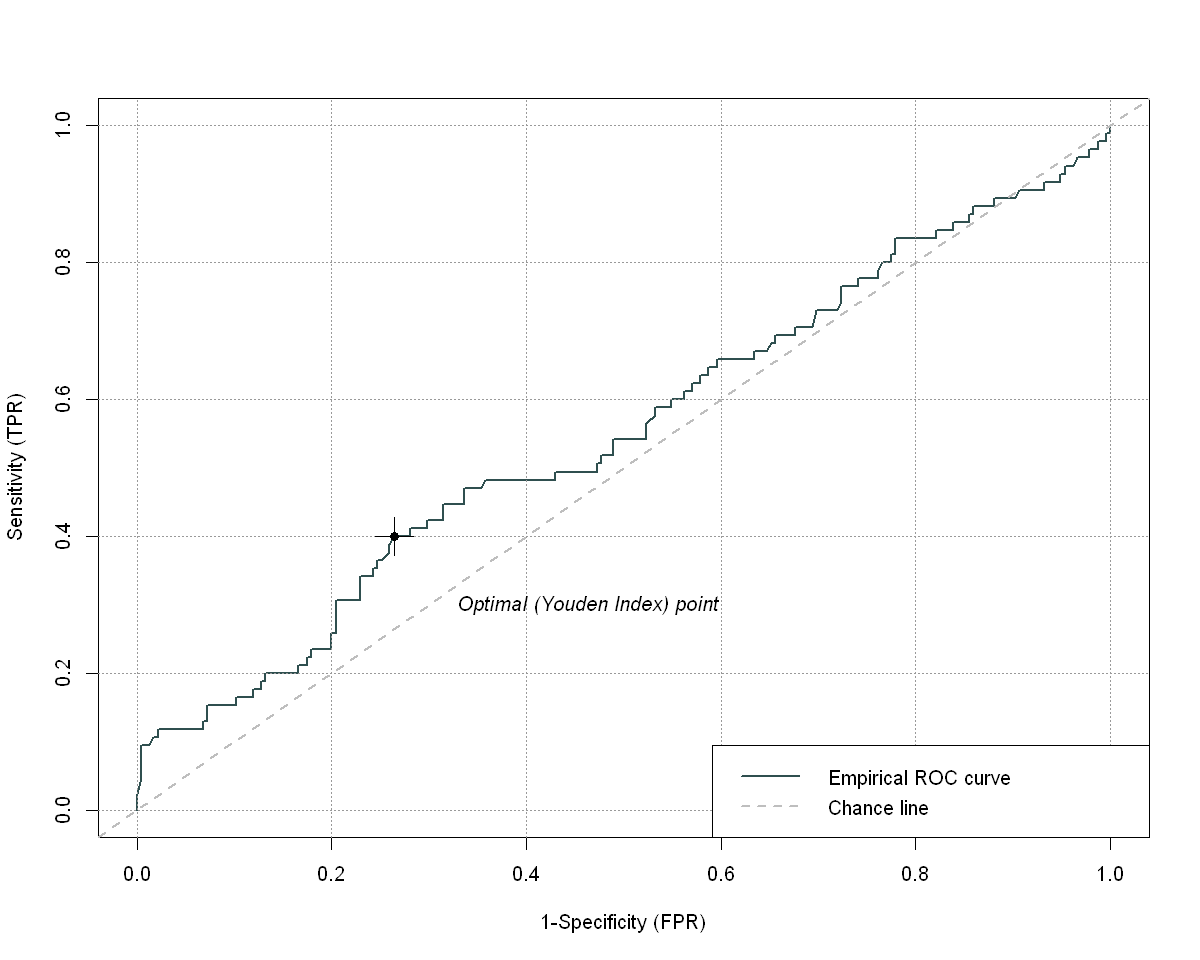

In [856]:
prob <- predict(rf_tuned, type = "prob", newdata = validation)[,2]
roc_curve_plot(prob,validation,"First.Payment.Default","SMOTE: Tuned Random Forest")

- We still have the same performance metrics. Lets look at the optimal point for threshold to obtain our final predictions. The decision to choose the optimal threshold should be based on individual costs associated to each of the four outcomes (TP, TN, FP and FN). We need to determine threshold based on how much cost each defaulting customer costs the company, and how much revenue is earned from each payment from non-defaulting customers. Based on the costs, we can determine the threshold which saves the maximum amount of money to the company.


- For now, we will use 0.5 as our threshold.

In [1009]:
#Applying on the test-set
final_prob <- predict(rf_tuned, type = "prob", newdata = test)[,2]
test$First.Payment.Default <- final_prob > 0.5
test %>% select(First.Payment.Default) %>% table()

.
FALSE  TRUE 
  285   115 

We have identified 115 applicants who might default.

### Important factors that indicate towards defaulting customers

In [1034]:
imp <- varImp(rf_tuned)
imp[order(-imp$Overall),,drop = FALSE]

,Overall
,<dbl>
Monthly.Net.Income,179.41801
Months.at.Residence,174.71645
Bank.Account.Months,170.82456
time.to.pay,163.61817
Loan.Amount,119.78182
time.to.review,64.49044
Pay.Cycle_BiWeekly,24.80786
Rent.or.Own_O,21.07547
Pay.Cycle_BiMonthly,18.42637


#### Monthly Net Income, Months lived at residence, Having a Bank Account for a long duration, time left for the due date and Loan amount - are all very important indicators for an applicant's first payment

### Extensions:
    We can do 2 things here. Create additional features, or collect more data.